Projeto Final Pós Graduação Big Data - Senac Rio - 2020.

Processo de importação das Bibliotecas utilizadas no durante todo o projeto.

In [1]:
#Importação das bibliotecas utilizadas para manipulação dos dados das paginas Web.

from datetime import datetime

print(f'Ativação das bibliotecas iniciada - {datetime.now()}.')

from bs4 import BeautifulSoup
import urllib.request
import shutil
import os
import pandas as pd
import pyspark
import zipfile
import sqlalchemy
import pymysql
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import * 

%matplotlib inline

print(f'Ativação das bibliotecas com sucesso - {datetime.now()}.')

Ativação das bibliotecas iniciada - 2020-09-02 17:50:57.109005.
Ativação das bibliotecas com sucesso - 2020-09-02 17:50:58.313954.


Indicação do diretório para download dos arquivos Inep-Enem. 

In [ ]:
#Indicação do diretório desejado para download dos arquivos. 
#No exemplo, estamos salvando no diretório: C:\Users\Ricardo\Downloads

diretorio = input('Digite o diretório desejado para salvar os arquivos: ')
os.chdir(r'{}'.format(diretorio))
os.getcwd( )

In [ ]:
#Apos indicar o diretorio desejado, como boa pratica, sugerimos a criação da pasta onde será salvos os arquivos.
#No exemplo, estamos salvando na pasta: MicrodadosEnem.'''

url = 'http://inep.gov.br/microdados'

pasta = input('Após indicação do diretório {}, informe o nome da pasta desejada para salvar os arquivos baixados da pagina {}: '.format(diretorio, url))

try:
    os.mkdir(pasta)
    print('Pasta {} criada com sucesso!'.format(pasta))
except FileExistsError as e:
    print(f'Pasta {pasta} já existe')

In [ ]:
#Indicação do diretório onde será salvo os arquivos baixados da url.

os.chdir(r'{}\{}'.format(diretorio, pasta))
print('Os arquivos serão salvos no seguinte diretorio:', format(os.getcwd()))

Processo de Web Scraping no site do Inep, buscando os microdados do Enem.

In [ ]:
#Criação da variável que receberá todos os dados correspondente a varíavel "url".

page = urllib.request.urlopen(url)

In [ ]:
#Criação da variável "soup", do pacote BeatifulSoup, que apresenta a estutura HTML da pagina que será trabalhada.

soup = BeautifulSoup(page,'html.parser')
print(soup)

In [ ]:
#No loop "for" abaixo, o realizaremos o filtro das tags desejadas.

for link in soup.findAll('a'):
    theLink = link.get('href')
    name = link.string
    
    print(theLink)
    print(name)

In [ ]:
#No processo abaixo, realizaremos o filtro das linhas, cujo o o tipo do arquivo desejado é *.zip.

nomeArquivo = []
typeFile = '.zip'
i = 0
for link in soup.findAll('a'):
    theLink = str(link.get('href')).lower()
    name = link.string
    if 'enem'in theLink:
        if theLink[-4:] == typeFile:
            print(theLink)
            print(type(theLink))
            print(name)
            print(type(name))
            nomeArquivo.append(theLink[39:-4].replace('/','_'))
            print(type(nomeArquivo))

In [ ]:
#Processo de download dos arquivos desejados e salvos na na pasta indicada.

i = 0
for link in soup.findAll('a'):
    theLink = str(link.get('href')).lower()
    name = link.string
    if 'enem'in theLink:
        if theLink[-4:] == typeFile:
            if name is None:
                title = 'SemTítulo' + typeFile
            else:
                title = nomeArquivo[i] + typeFile
                i +=1
            try:
                with open(os.getcwd() + '/' + title,'r') as fileExists:
                    print('Arquivo ' + title + ' existente no diretório '+ os.getcwd() + ' - ' + str(datetime.now()))
                    fileExists.close()
            except FileNotFoundError:
                print('Download Iniciado - {}: '.format(datetime.now()) + title)
                docFile = open(os.getcwd() + '/' + title,'wb')
                docFile.write(urllib.request.urlopen(theLink).read())
                docFile.close()
                print('Download Concluído em {}'.format(datetime.now()))
print('Não há mais arquivos para download')

In [ ]:
#Apresentação do tamanho dos arquivos baixados.

print('Apresentação Arquivos Enem baixados no díretório: ' + os.getcwd())
contador = 0
tamanhoTotal = 0
tipo = '.zip'

def formatarTamanho(tamanho):
    base = 1024
    kilo = base
    mega = base ** 2
    giga = base ** 3
    tera = base ** 4
    
    if tamanho < kilo:
        tamanho = base
        texto = 'B'
    elif tamanho < mega:
        tamanho /= kilo
        texto = 'K'
    elif tamanho < giga:
        tamanho /= mega
        texto = 'M'
    else:
        tamanho < tera
        tamanho /= giga
        texto = 'G'
    tamanho = round(tamanho, 2)
    return f'{tamanho} {texto}'

for raiz, diretorios, arquivos in os.walk(os.getcwd()):
    for arquivo in arquivos:
        if tipo in arquivo:
            contador +=1 
            caminho = os.path.join(raiz, arquivo)
            nome, ext = os.path.splitext(arquivo)
            tamanho = os.path.getsize(caminho)
            tamanhoTotal += tamanho
                                
            if tamanho > 0:
                print()
                print('Arquivo encontrado: ', arquivo)
                print('Caminho: ', caminho)
                print('Nome: ', nome)
                print('Extensão: ', ext)
                print('Tamanho: ', formatarTamanho(tamanho))

print()
print(f'{contador} arquivo(s) encontrado(s).' + 'Tamanho Total: ' + formatarTamanho(tamanhoTotal))

Processo de Intaciação do Spark e criação dos Dataframes, atraves dos arquivos CSV's do Enem. 

In [2]:
# Instanciar Spark

print(f'Intanciando o Spark - {datetime.now()}.')

sc = SparkContext()
sqlContext = SQLContext(sc)

print(f'Spark intanciado com sucesso - {datetime.now()}.')

Intanciando o Spark - 2020-09-02 17:51:26.489611.
Spark intanciado com sucesso - 2020-09-02 17:51:37.758769.


In [3]:
# No Processo abaixo, importaremos para o dataframe, apenas para conhecer os dados e verificar o separador do microdado.

print(f'Criação Dataframes Iniciado - {datetime.now()}.')
print('')

print('')
print(f'Criação Dataframe do Enem 2015 iniciada - {datetime.now()}.')
df_enem2015_completo = sqlContext.read.format('com.databricks.spark.csv').options(header='true', sep=",", inferschema='true', encoding = 'ISO-8859-1', ).load(r'C:\Users\Ricardo\Downloads\MicrodadosEnem\MICRODADOS_ENEM_2015.csv')
print(f'Dataframe df_enem2015_completo criado com sucesso - {datetime.now()}.')
print('')

print(f'Criação Dataframe do Enem 2016 iniciada- {datetime.now()}.')
df_enem2016_completo = sqlContext.read.format('com.databricks.spark.csv').options(header='true', sep=";", inferschema='true', encoding = 'ISO-8859-1').load(r'C:\Users\Ricardo\Downloads\MicrodadosEnem\microdados_enem_2016.csv')
print(f'Dataframe df_enem2016_completo criado com sucesso - {datetime.now()}.')
print('')

print(f'Criação Dataframe do Enem 2017 iniciada - {datetime.now()}.')
df_enem2017_completo = sqlContext.read.format('com.databricks.spark.csv').options(header='true', sep=";", inferschema='true', encoding = 'ISO-8859-1').load(r'C:\Users\Ricardo\Downloads\MicrodadosEnem\MICRODADOS_ENEM_2017.csv')
print(f'Dataframe df_enem2017_completo criado com sucesso - {datetime.now()}.')
print('')

print(f'Criação Dataframe do Enem 2018 iniciada - {datetime.now()}.')
df_enem2018_completo = sqlContext.read.format('com.databricks.spark.csv').options(header='true', sep=";", inferschema='true', encoding = 'ISO-8859-1').load(r'C:\Users\Ricardo\Downloads\MicrodadosEnem\MICRODADOS_ENEM_2018.csv')
print(f'Dataframe df_enem2018_completo criado com sucesso - {datetime.now()}.')
print('')

print(f'Criação Dataframe do Enem 2019 iniciada - {datetime.now()}.')
df_enem2019_completo = sqlContext.read.format('com.databricks.spark.csv').options(header='true', sep=";", inferschema='true', encoding = 'ISO-8859-1').load(r'C:\Users\Ricardo\Downloads\MicrodadosEnem\MICRODADOS_ENEM_2019.csv')
print(f'Dataframe df_enem2019_completo criado com sucesso - {datetime.now()}.')
print('')

print('')
print(f'Dataframes criados com sucesso - {datetime.now()}.')

Criação Dataframes Iniciado - 2020-09-02 17:51:37.836560.


Criação Dataframe do Enem 2015 iniciada - 2020-09-02 17:51:37.837559.
Dataframe df_enem2015_completo criado com sucesso - 2020-09-02 17:52:27.912356.

Criação Dataframe do Enem 2016 iniciada- 2020-09-02 17:52:27.914350.
Dataframe df_enem2016_completo criado com sucesso - 2020-09-02 17:53:19.341446.

Criação Dataframe do Enem 2017 iniciada - 2020-09-02 17:53:19.342443.
Dataframe df_enem2017_completo criado com sucesso - 2020-09-02 17:53:52.066797.

Criação Dataframe do Enem 2018 iniciada - 2020-09-02 17:53:52.067793.
Dataframe df_enem2018_completo criado com sucesso - 2020-09-02 17:54:19.586942.

Criação Dataframe do Enem 2019 iniciada - 2020-09-02 17:54:19.587939.
Dataframe df_enem2019_completo criado com sucesso - 2020-09-02 17:54:45.541547.


Dataframes criados com sucesso - 2020-09-02 17:54:45.542544.


In [4]:
# Apresentação dos registros de cada dataframe

print('Quantidade de Registros importadados para cada Dataframe')
print('')

print(f'Quantdade de Registros Dataframe Enem2015 - {datetime.now()}.')
print(df_enem2015_completo.count())
print('')

print(f'Quantdade de Registros Dataframe Enem2016 - {datetime.now()}.')
print(df_enem2016_completo.count())
print('')

print(f'Quantdade de Registros Dataframe Enem2017 - {datetime.now()}.')
print(df_enem2017_completo.count())
print('')

print(f'Quantdade de Registros Dataframe Enem2018 - {datetime.now()}.')
print(df_enem2018_completo.count())
print('')

print(f'Quantdade de Registros Dataframe Enem2019 - {datetime.now()}.')
print(df_enem2019_completo.count())


Quantidade de Registros importadados para cada Dataframe

Quantdade de Registros Dataframe Enem2015 - 2020-09-02 17:54:45.579445.
7746427

Quantdade de Registros Dataframe Enem2016 - 2020-09-02 17:55:08.843610.
8627367

Quantdade de Registros Dataframe Enem2017 - 2020-09-02 17:55:33.805536.
6731341

Quantdade de Registros Dataframe Enem2018 - 2020-09-02 17:55:50.200179.
5513747

Quantdade de Registros Dataframe Enem2019 - 2020-09-02 17:56:04.513854.
5095270


In [5]:
# Apresentação de duas linhas do dataframe df_enem2015_completo

print(f'Apresentação de duas linhas do dataframe df_enem2015_completo - {datetime.now()}.')

df_enem2015_completo.show(n=2,truncate=True)

Apresentação de duas linhas do dataframe df_enem2015_completo - 2020-09-02 17:56:16.246288.
+------------+------+-----------------------+-----------------------+----------------+----------------+---------------------------+------------+---------+----------------+----------------+---------+---------+----------------------+------------------+---------------+--------+-------+----------------+-----------------------+-----------------------+----------------+----------------+---------------+---------------+---------+---------+---------------+-----------+--------------+-----------+---------+-----------------------+-----------------+---------------------+---------------------+------------------+-----------+-----------+-----------+--------+--------------+----------+------------------+------------+------------+--------------+--------------+----------+--------------+--------------+--------+---------+--------------+---------+-----------------+---------------------+------------------------+--------

In [6]:
# Apresentação de duas linhas do dataframe df_enem2015_completo

print(f'Apresentação de duas linhas do dataframe df_enem2015_completo, classificado como linhas - {datetime.now()}.')

df_enem2015_completo.head(2)

Apresentação de duas linhas do dataframe df_enem2015_completo, classificado como linhas - 2020-09-02 17:56:16.957385.


[Row(NU_INSCRICAO=150000000376, NU_ANO=2015, CO_MUNICIPIO_RESIDENCIA=4309209, NO_MUNICIPIO_RESIDENCIA='Gravataí', CO_UF_RESIDENCIA=43, SG_UF_RESIDENCIA='RS', IN_ESTUDA_CLASSE_HOSPITALAR=0, IN_TREINEIRO=0, CO_ESCOLA=None, CO_MUNICIPIO_ESC=None, NO_MUNICIPIO_ESC=None, CO_UF_ESC=None, SG_UF_ESC=None, TP_DEPENDENCIA_ADM_ESC=None, TP_LOCALIZACAO_ESC=None, TP_SIT_FUNC_ESC=None, NU_IDADE=42, TP_SEXO='M', TP_NACIONALIDADE=1, CO_MUNICIPIO_NASCIMENTO=4209003, NO_MUNICIPIO_NASCIMENTO='Joaçaba', CO_UF_NASCIMENTO=42, SG_UF_NASCIMENTO='SC', TP_ST_CONCLUSAO=1, TP_ANO_CONCLUIU=10, TP_ESCOLA=1, TP_ENSINO=None, TP_ESTADO_CIVIL=1, TP_COR_RACA=1, IN_BAIXA_VISAO=0, IN_CEGUEIRA=0, IN_SURDEZ=0, IN_DEFICIENCIA_AUDITIVA=0, IN_SURDO_CEGUEIRA=0, IN_DEFICIENCIA_FISICA=0, IN_DEFICIENCIA_MENTAL=0, IN_DEFICIT_ATENCAO=0, IN_DISLEXIA=0, IN_GESTANTE=0, IN_LACTANTE=0, IN_IDOSO=0, IN_DISCALCULIA=0, IN_AUTISMO=0, IN_VISAO_MONOCULAR=0, IN_SABATISTA=0, IN_OUTRA_DEF=0, IN_SEM_RECURSO=0, IN_NOME_SOCIAL=0, IN_BRAILLE=0, IN_AMP

In [7]:
# Apresentação da estutura do dataframe df_enem2015_completo

print(f'Apresentação da estutura do dataframe df_enem2015_completo - {datetime.now()}.')

df_enem2015_completo.printSchema()

Apresentação da estutura do dataframe df_enem2015_completo - 2020-09-02 17:56:17.128928.
root
 |-- NU_INSCRICAO: long (nullable = true)
 |-- NU_ANO: integer (nullable = true)
 |-- CO_MUNICIPIO_RESIDENCIA: integer (nullable = true)
 |-- NO_MUNICIPIO_RESIDENCIA: string (nullable = true)
 |-- CO_UF_RESIDENCIA: integer (nullable = true)
 |-- SG_UF_RESIDENCIA: string (nullable = true)
 |-- IN_ESTUDA_CLASSE_HOSPITALAR: integer (nullable = true)
 |-- IN_TREINEIRO: integer (nullable = true)
 |-- CO_ESCOLA: integer (nullable = true)
 |-- CO_MUNICIPIO_ESC: integer (nullable = true)
 |-- NO_MUNICIPIO_ESC: string (nullable = true)
 |-- CO_UF_ESC: integer (nullable = true)
 |-- SG_UF_ESC: string (nullable = true)
 |-- TP_DEPENDENCIA_ADM_ESC: integer (nullable = true)
 |-- TP_LOCALIZACAO_ESC: integer (nullable = true)
 |-- TP_SIT_FUNC_ESC: integer (nullable = true)
 |-- NU_IDADE: integer (nullable = true)
 |-- TP_SEXO: string (nullable = true)
 |-- TP_NACIONALIDADE: integer (nullable = true)
 |-- CO

In [8]:
# Apresentação das colunas do dataframe df_enem2015_completo

print(f'Apresentação das colunas do dataframe df_enem2015_completo - {datetime.now()}.')

df_enem2015_completo.columns[:]

Apresentação das colunas do dataframe df_enem2015_completo - 2020-09-02 17:56:17.161838.


['NU_INSCRICAO',
 'NU_ANO',
 'CO_MUNICIPIO_RESIDENCIA',
 'NO_MUNICIPIO_RESIDENCIA',
 'CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'IN_ESTUDA_CLASSE_HOSPITALAR',
 'IN_TREINEIRO',
 'CO_ESCOLA',
 'CO_MUNICIPIO_ESC',
 'NO_MUNICIPIO_ESC',
 'CO_UF_ESC',
 'SG_UF_ESC',
 'TP_DEPENDENCIA_ADM_ESC',
 'TP_LOCALIZACAO_ESC',
 'TP_SIT_FUNC_ESC',
 'NU_IDADE',
 'TP_SEXO',
 'TP_NACIONALIDADE',
 'CO_MUNICIPIO_NASCIMENTO',
 'NO_MUNICIPIO_NASCIMENTO',
 'CO_UF_NASCIMENTO',
 'SG_UF_NASCIMENTO',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_ESTADO_CIVIL',
 'TP_COR_RACA',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DEFICIENCIA_AUDITIVA',
 'IN_SURDO_CEGUEIRA',
 'IN_DEFICIENCIA_FISICA',
 'IN_DEFICIENCIA_MENTAL',
 'IN_DEFICIT_ATENCAO',
 'IN_DISLEXIA',
 'IN_GESTANTE',
 'IN_LACTANTE',
 'IN_IDOSO',
 'IN_DISCALCULIA',
 'IN_AUTISMO',
 'IN_VISAO_MONOCULAR',
 'IN_SABATISTA',
 'IN_OUTRA_DEF',
 'IN_SEM_RECURSO',
 'IN_NOME_SOCIAL',
 'IN_BRAILLE',
 'IN_AMPLIADA_24',
 'IN_AMPLIADA_18',
 'IN_L

In [9]:
# Descrição Dataframe df_enem2015_completo.

print('Descrição DataFrame df_enem2015_completo')
print('')

print('Descrição Idade')
df_enem2015_completo.describe('NU_IDADE').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Ciências da Natureza')
df_enem2015_completo.describe('NU_NOTA_CN').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Ciências Humanas')
df_enem2015_completo.describe('NU_NOTA_CH').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Linguagens e Códigos')
df_enem2015_completo.describe('NU_NOTA_LC').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Matemática')
df_enem2015_completo.describe('NU_NOTA_MT').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de redação')
df_enem2015_completo.describe('NU_NOTA_REDACAO').show()
print(f'{datetime.now()}.')

Descrição DataFrame df_enem2015_completo

Descrição Idade
+-------+------------------+
|summary|          NU_IDADE|
+-------+------------------+
|  count|           7746352|
|   mean|23.004694338702915|
| stddev| 7.944599707765686|
|    min|                10|
|    max|                98|
+-------+------------------+

2020-09-02 17:56:38.564970.

Descrição Nota da prova de Ciências da Natureza
+-------+-----------------+
|summary|       NU_NOTA_CN|
+-------+-----------------+
|  count|          5755091|
|   mean|478.9239503771539|
| stddev|71.56005864237716|
|    min|              0.0|
|    max|            875.2|
+-------+-----------------+

2020-09-02 17:56:54.719640.

Descrição Nota da prova de Ciências Humanas
+-------+-----------------+
|summary|       NU_NOTA_CH|
+-------+-----------------+
|  count|          5755091|
|   mean|558.4878240152929|
| stddev|70.96839011437301|
|    min|              0.0|
|    max|            850.6|
+-------+-----------------+

2020-09-02 17:57:10.8196

In [10]:
# Descrição Dataframe df_enem2016_completo.

print('Descrição DataFrame df_enem2016_completo')
print('')

print('Descrição Idade')
df_enem2016_completo.describe('NU_IDADE').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Ciências da Natureza')
df_enem2016_completo.describe('NU_NOTA_CN').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Ciências Humanas')
df_enem2016_completo.describe('NU_NOTA_CH').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Linguagens e Códigos')
df_enem2016_completo.describe('NU_NOTA_LC').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Matemática')
df_enem2016_completo.describe('NU_NOTA_MT').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de redação')
df_enem2016_completo.describe('NU_NOTA_REDACAO').show()
print(f'{datetime.now()}.')

Descrição DataFrame df_enem2016_completo

Descrição Idade
+-------+-----------------+
|summary|         NU_IDADE|
+-------+-----------------+
|  count|          8627265|
|   mean| 23.0310825041308|
| stddev|7.973406085745136|
|    min|               10|
|    max|               95|
+-------+-----------------+

2020-09-02 17:58:25.077135.

Descrição Nota da prova de Ciências da Natureza
+-------+-----------------+
|summary|       NU_NOTA_CN|
+-------+-----------------+
|  count|          5999126|
|   mean|477.6773009101653|
| stddev|72.71845884040538|
|    min|              0.0|
|    max|            871.3|
+-------+-----------------+

2020-09-02 17:58:44.063053.

Descrição Nota da prova de Ciências Humanas
+-------+-----------------+
|summary|       NU_NOTA_CH|
+-------+-----------------+
|  count|          5999126|
|   mean|534.4409175603251|
| stddev| 74.4988507782099|
|    min|              0.0|
|    max|            859.1|
+-------+-----------------+

2020-09-02 17:59:03.489098.

Desc

In [11]:
# Descrição Dataframe df_enem2017_completo.

print('Descrição DataFrame df_enem2017_completo')
print('')

print('Descrição Idade')
df_enem2017_completo.describe('NU_IDADE').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Ciências da Natureza')
df_enem2017_completo.describe('NU_NOTA_CN').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Ciências Humanas')
df_enem2017_completo.describe('NU_NOTA_CH').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Linguagens e Códigos')
df_enem2017_completo.describe('NU_NOTA_LC').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Matemática')
df_enem2017_completo.describe('NU_NOTA_MT').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de redação')
df_enem2017_completo.describe('NU_NOTA_REDACAO').show()
print(f'{datetime.now()}.')

Descrição DataFrame df_enem2017_completo

Descrição Idade
+-------+-----------------+
|summary|         NU_IDADE|
+-------+-----------------+
|  count|          6731240|
|   mean|22.95379261473369|
| stddev|7.728937918555041|
|    min|               10|
|    max|               90|
+-------+-----------------+

2020-09-02 18:00:15.977027.

Descrição Nota da prova de Ciências da Natureza
+-------+-----------------+
|summary|       NU_NOTA_CN|
+-------+-----------------+
|  count|          4437560|
|   mean|510.8619317147265|
| stddev|72.12733741911008|
|    min|              0.0|
|    max|            885.6|
+-------+-----------------+

2020-09-02 18:00:28.828840.

Descrição Nota da prova de Ciências Humanas
+-------+-----------------+
|summary|       NU_NOTA_CH|
+-------+-----------------+
|  count|          4701428|
|   mean|518.8259502219317|
| stddev|83.41395391030184|
|    min|              0.0|
|    max|            868.3|
+-------+-----------------+

2020-09-02 18:00:41.759439.

Desc

In [12]:
# Descrição Dataframe df_enem2018_completo.

print('Descrição DataFrame df_enem2018_completo')
print('')

print('Descrição Idade')
df_enem2018_completo.describe('NU_IDADE').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Ciências da Natureza')
df_enem2018_completo.describe('NU_NOTA_CN').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Ciências Humanas')
df_enem2018_completo.describe('NU_NOTA_CH').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Linguagens e Códigos')
df_enem2018_completo.describe('NU_NOTA_LC').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Matemática')
df_enem2018_completo.describe('NU_NOTA_MT').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de redação')
df_enem2018_completo.describe('NU_NOTA_REDACAO').show()
print(f'{datetime.now()}.')

Descrição DataFrame df_enem2018_completo

Descrição Idade
+-------+------------------+
|summary|          NU_IDADE|
+-------+------------------+
|  count|           5513650|
|   mean|22.372219854361447|
| stddev| 7.594597160609549|
|    min|                10|
|    max|                98|
+-------+------------------+

2020-09-02 18:01:36.151275.

Descrição Nota da prova de Ciências da Natureza
+-------+-----------------+
|summary|       NU_NOTA_CN|
+-------+-----------------+
|  count|          3905099|
|   mean|493.6832652129926|
| stddev|  74.165826188305|
|    min|              0.0|
|    max|            869.6|
+-------+-----------------+

2020-09-02 18:01:47.492982.

Descrição Nota da prova de Ciências Humanas
+-------+-----------------+
|summary|       NU_NOTA_CH|
+-------+-----------------+
|  count|          4148264|
|   mean|568.0977346186262|
| stddev|81.41996050791391|
|    min|              0.0|
|    max|            850.4|
+-------+-----------------+

2020-09-02 18:01:58.7584

In [13]:
# Descrição Dataframe df_enem2019_completo.

print('Descrição DataFrame df_enem2019_completo')
print('')

print('Descrição Idade')
df_enem2019_completo.describe('NU_IDADE').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Ciências da Natureza')
df_enem2019_completo.describe('NU_NOTA_CN').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Ciências Humanas')
df_enem2019_completo.describe('NU_NOTA_CH').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Linguagens e Códigos')
df_enem2019_completo.describe('NU_NOTA_LC').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Matemática')
df_enem2019_completo.describe('NU_NOTA_MT').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de redação')
df_enem2019_completo.describe('NU_NOTA_REDACAO').show()
print(f'{datetime.now()}.')

Descrição DataFrame df_enem2019_completo

Descrição Idade
+-------+-----------------+
|summary|         NU_IDADE|
+-------+-----------------+
|  count|          5095270|
|   mean|22.08743069552742|
| stddev|7.454970482110064|
|    min|                1|
|    max|               94|
+-------+-----------------+

2020-09-02 18:02:49.820497.

Descrição Nota da prova de Ciências da Natureza
+-------+------------------+
|summary|        NU_NOTA_CN|
+-------+------------------+
|  count|           3710433|
|   mean|477.82408735045146|
| stddev| 76.09774469638398|
|    min|               0.0|
|    max|             860.9|
+-------+------------------+

2020-09-02 18:02:59.914500.

Descrição Nota da prova de Ciências Humanas
+-------+-----------------+
|summary|       NU_NOTA_CH|
+-------+-----------------+
|  count|          3923145|
|   mean|507.2486632280978|
| stddev| 82.4116343330404|
|    min|              0.0|
|    max|            835.1|
+-------+-----------------+

2020-09-02 18:03:10.3186

In [14]:
# Criação e seleção das colunas para realização das analises exploratórias

print(f'Criação da variável columns e seleção das colunas para realização das analises exploratórias - {datetime.now()}.')

columns = [
'NU_INSCRICAO', 
'NU_ANO', 
'NO_MUNICIPIO_RESIDENCIA', 
'CO_UF_RESIDENCIA', 
'SG_UF_RESIDENCIA',
'NU_IDADE', 
'TP_SEXO', 
'TP_ESTADO_CIVIL',
'TP_COR_RACA', 
'TP_NACIONALIDADE',
'NO_MUNICIPIO_NASCIMENTO',
'CO_UF_NASCIMENTO', 
'SG_UF_NASCIMENTO', 
'TP_ST_CONCLUSAO',
'TP_ESCOLA', 
'TP_ENSINO', 
'IN_TREINEIRO', 
'CO_UF_ESC', 
'SG_UF_ESC',
'TP_DEPENDENCIA_ADM_ESC', 
'TP_LOCALIZACAO_ESC', 
'IN_BAIXA_VISAO', 
'IN_CEGUEIRA', 
'IN_SURDEZ',
'IN_DEFICIENCIA_AUDITIVA', 
'IN_SURDO_CEGUEIRA',
'IN_DEFICIENCIA_FISICA', 
'IN_DEFICIENCIA_MENTAL',
'IN_DEFICIT_ATENCAO', 
'IN_DISLEXIA', 
'IN_DISCALCULIA', 
'IN_AUTISMO', 
'IN_VISAO_MONOCULAR',
'IN_OUTRA_DEF', 
'IN_GESTANTE', 
'IN_LACTANTE',
'IN_IDOSO', 
'IN_ESTUDA_CLASSE_HOSPITALAR', 
'IN_SEM_RECURSO', 
'IN_BRAILLE', 
'IN_AMPLIADA_24', 
'IN_AMPLIADA_18', 
'IN_LEDOR',
'IN_ACESSO', 
'IN_TRANSCRICAO', 
'IN_LIBRAS', 
'IN_LEITURA_LABIAL',
'IN_MESA_CADEIRA_RODAS', 
'IN_MESA_CADEIRA_SEPARADA',
'IN_APOIO_PERNA', 
'IN_GUIA_INTERPRETE', 
'IN_COMPUTADOR',
'IN_CADEIRA_ESPECIAL', 
'IN_CADEIRA_CANHOTO',
'IN_CADEIRA_ACOLCHOADA', 
'IN_PROVA_DEITADO', 
'IN_MOBILIARIO_OBESO',
'IN_LAMINA_OVERLAY', 
'IN_PROTETOR_AURICULAR', 
'IN_MEDIDOR_GLICOSE',
'IN_MAQUINA_BRAILE', 
'IN_SOROBAN', 
'IN_MARCA_PASSO', 
'IN_SONDA',
'IN_MEDICAMENTOS', 
'IN_SALA_INDIVIDUAL', 
'IN_SALA_ESPECIAL',
'IN_SALA_ACOMPANHANTE', 
'IN_MOBILIARIO_ESPECIFICO',
'IN_NOME_SOCIAL',
'NO_MUNICIPIO_PROVA', 
'CO_UF_PROVA', 
'SG_UF_PROVA',
'TP_PRESENCA_CN', 
'TP_PRESENCA_CH', 
'TP_PRESENCA_LC',
'TP_PRESENCA_MT', 
'NU_NOTA_CN', 
'NU_NOTA_CH', 
'NU_NOTA_LC',
'NU_NOTA_MT', 
'TP_LINGUA',
'TP_STATUS_REDACAO', 
'NU_NOTA_COMP1',
'NU_NOTA_COMP2', 
'NU_NOTA_COMP3', 
'NU_NOTA_COMP4', 
'NU_NOTA_COMP5',
'NU_NOTA_REDACAO', 
'Q001', 
'Q002', 
'Q005', 
'Q006',
'Q022',
'Q024', 
'Q025'
]


Criação da variável columns e seleção das colunas para realização das analises exploratórias - 2020-09-02 18:03:40.192523.


In [15]:
# No Processo abaixo, criaremos dataframes, apenas com colunas selecionadas.

print(f'Criação Dataframes Iniciado - {datetime.now()}.')
print('')

print('')
print(f'Criação Dataframe do Enem 2015 iniciada - {datetime.now()}.')
df_enem2015 = df_enem2015_completo.select(columns)
print(f'Dataframe df_enem2015 criado com sucesso - {datetime.now()}.')
print('')

print('')
print(f'Criação Dataframe do Enem 2016 iniciada - {datetime.now()}.')
df_enem2016 = df_enem2016_completo.select(columns)
print(f'Dataframe df_enem2016 criado com sucesso - {datetime.now()}.')
print('')

print('')
print(f'Criação Dataframe do Enem 2017 iniciada - {datetime.now()}.')
df_enem2017 = df_enem2017_completo.select(columns)
print(f'Dataframe df_enem2017 criado com sucesso - {datetime.now()}.')
print('')

print('')
print(f'Criação Dataframe do Enem 2018 iniciada - {datetime.now()}.')
df_enem2018 = df_enem2018_completo.select(columns)
print(f'Dataframe df_enem2018 criado com sucesso - {datetime.now()}.')
print('')

print('')
print(f'Criação Dataframe do Enem 2019 iniciada - {datetime.now()}.')
df_enem2019 = df_enem2019_completo.select(columns)
print(f'Dataframe df_enem2019 criado com sucesso - {datetime.now()}.')
print('')


Criação Dataframes Iniciado - 2020-09-02 18:03:40.225437.


Criação Dataframe do Enem 2015 iniciada - 2020-09-02 18:03:40.225437.
Dataframe df_enem2015 criado com sucesso - 2020-09-02 18:03:40.490726.


Criação Dataframe do Enem 2016 iniciada - 2020-09-02 18:03:40.491724.
Dataframe df_enem2016 criado com sucesso - 2020-09-02 18:03:40.777958.


Criação Dataframe do Enem 2017 iniciada - 2020-09-02 18:03:40.778955.
Dataframe df_enem2017 criado com sucesso - 2020-09-02 18:03:41.091122.


Criação Dataframe do Enem 2018 iniciada - 2020-09-02 18:03:41.092120.
Dataframe df_enem2018 criado com sucesso - 2020-09-02 18:03:41.347437.


Criação Dataframe do Enem 2019 iniciada - 2020-09-02 18:03:41.347437.
Dataframe df_enem2019 criado com sucesso - 2020-09-02 18:03:41.562859.



In [16]:
# Criação de um dataframe uníco, com a união de todos os dataframes criados. 

print(f'Criação Dataframe do df_enem iniciada - {datetime.now()}.')

df_enem = df_enem2015.unionAll(df_enem2016).unionAll(df_enem2017).unionAll(df_enem2018).unionAll(df_enem2019)

print(f'Dataframe df_enem criado com sucesso - {datetime.now()}.')

Criação Dataframe do df_enem iniciada - 2020-09-02 18:03:41.590783.
Dataframe df_enem criado com sucesso - 2020-09-02 18:03:41.656607.


In [17]:
# Total de linhas do dataframe df_enem

print(f'Quantdade de Registros Dataframe df_enem - {datetime.now()}.')

df_enem.count()

Quantdade de Registros Dataframe df_enem - 2020-09-02 18:03:41.681543.


33714152

In [18]:
# Apresentação das colunas do dataframe df_enem.

print(f'Apresentação das colunas do dataframe df_enem - {datetime.now()}.')

df_enem.columns[:]

Apresentação das colunas do dataframe df_enem - 2020-09-02 18:05:19.975336.


['NU_INSCRICAO',
 'NU_ANO',
 'NO_MUNICIPIO_RESIDENCIA',
 'CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_SEXO',
 'TP_ESTADO_CIVIL',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'NO_MUNICIPIO_NASCIMENTO',
 'CO_UF_NASCIMENTO',
 'SG_UF_NASCIMENTO',
 'TP_ST_CONCLUSAO',
 'TP_ESCOLA',
 'TP_ENSINO',
 'IN_TREINEIRO',
 'CO_UF_ESC',
 'SG_UF_ESC',
 'TP_DEPENDENCIA_ADM_ESC',
 'TP_LOCALIZACAO_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DEFICIENCIA_AUDITIVA',
 'IN_SURDO_CEGUEIRA',
 'IN_DEFICIENCIA_FISICA',
 'IN_DEFICIENCIA_MENTAL',
 'IN_DEFICIT_ATENCAO',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_AUTISMO',
 'IN_VISAO_MONOCULAR',
 'IN_OUTRA_DEF',
 'IN_GESTANTE',
 'IN_LACTANTE',
 'IN_IDOSO',
 'IN_ESTUDA_CLASSE_HOSPITALAR',
 'IN_SEM_RECURSO',
 'IN_BRAILLE',
 'IN_AMPLIADA_24',
 'IN_AMPLIADA_18',
 'IN_LEDOR',
 'IN_ACESSO',
 'IN_TRANSCRICAO',
 'IN_LIBRAS',
 'IN_LEITURA_LABIAL',
 'IN_MESA_CADEIRA_RODAS',
 'IN_MESA_CADEIRA_SEPARADA',
 'IN_APOIO_PERNA',
 'IN_GUIA_INTERPRETE',
 'IN_COMPUTADOR

In [19]:
# Apresentação da estutura do dataframe df_enem

print(f'Apresentação da estutura do dataframe df_enem - {datetime.now()}.')

df_enem.printSchema()

Apresentação da estutura do dataframe df_enem - 2020-09-02 18:05:20.011241.
root
 |-- NU_INSCRICAO: long (nullable = true)
 |-- NU_ANO: integer (nullable = true)
 |-- NO_MUNICIPIO_RESIDENCIA: string (nullable = true)
 |-- CO_UF_RESIDENCIA: integer (nullable = true)
 |-- SG_UF_RESIDENCIA: string (nullable = true)
 |-- NU_IDADE: integer (nullable = true)
 |-- TP_SEXO: string (nullable = true)
 |-- TP_ESTADO_CIVIL: integer (nullable = true)
 |-- TP_COR_RACA: integer (nullable = true)
 |-- TP_NACIONALIDADE: integer (nullable = true)
 |-- NO_MUNICIPIO_NASCIMENTO: string (nullable = true)
 |-- CO_UF_NASCIMENTO: integer (nullable = true)
 |-- SG_UF_NASCIMENTO: string (nullable = true)
 |-- TP_ST_CONCLUSAO: integer (nullable = true)
 |-- TP_ESCOLA: integer (nullable = true)
 |-- TP_ENSINO: integer (nullable = true)
 |-- IN_TREINEIRO: integer (nullable = true)
 |-- CO_UF_ESC: integer (nullable = true)
 |-- SG_UF_ESC: string (nullable = true)
 |-- TP_DEPENDENCIA_ADM_ESC: integer (nullable = true

In [20]:
# Descrição Dataframe df_enem.

print(f'Descrição DataFrame df_enem (Dataframe com os anos 2015, 2016, 2017, 2018 e 2019) - {datetime.now()}.')
print('')

print('Descrição Idade')
df_enem.describe('NU_IDADE').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Ciências da Natureza')
df_enem.describe('NU_NOTA_CN').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Ciências Humanas')
df_enem.describe('NU_NOTA_CH').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Linguagens e Códigos')
df_enem.describe('NU_NOTA_LC').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de Matemática')
df_enem.describe('NU_NOTA_MT').show()
print(f'{datetime.now()}.')
print('')

print('Descrição Nota da prova de redação')
df_enem.describe('NU_NOTA_REDACAO').show()
print(f'{datetime.now()}.')

Descrição DataFrame df_enem (Dataframe com os anos 2015, 2016, 2017, 2018 e 2019) - 2020-09-02 18:05:20.029222.

Descrição Idade
+-------+------------------+
|summary|          NU_IDADE|
+-------+------------------+
|  count|          33713777|
|   mean|22.759218345663257|
| stddev| 7.788652341876025|
|    min|                 1|
|    max|                98|
+-------+------------------+

2020-09-02 18:06:50.088502.

Descrição Nota da prova de Ciências da Natureza
+-------+-----------------+
|summary|       NU_NOTA_CN|
+-------+-----------------+
|  count|         23807309|
|   mean|486.8124319678461|
| stddev|74.22313690738514|
|    min|              0.0|
|    max|            885.6|
+-------+-----------------+

2020-09-02 18:08:22.622362.

Descrição Nota da prova de Ciências Humanas
+-------+-----------------+
|summary|       NU_NOTA_CH|
+-------+-----------------+
|  count|         24527054|
|   mean|538.4331498189712|
| stddev|80.97454950674937|
|    min|              0.0|
|    max| 

In [21]:
# Criar tabela temporaria e usar sql para consulta

print(f'Apresentação do processo de criação de uma tabela temporária para utilização do SQL - {datetime.now()}.')

df_enem.createOrReplaceTempView('enemtb')
teste = sqlContext.sql('SELECT NU_INSCRICAO FROM enemtb').show()

print(f'{datetime.now()}.')

Apresentação do processo de criação de uma tabela temporária para utilização do SQL - 2020-09-02 18:14:34.454728.
+------------+
|NU_INSCRICAO|
+------------+
|150000000376|
|150000003053|
|150000001161|
|150000001335|
|150000001219|
|150000002884|
|150000002510|
|150000000658|
|150000000434|
|150000000216|
|150000000274|
|150000000217|
|150000000164|
|150000000165|
|150000000218|
|150000000166|
|150000000219|
|150000000275|
|150000000220|
|150000000167|
+------------+
only showing top 20 rows

2020-09-02 18:14:35.307447.


In [22]:
# Criação das colunas de classificação do dataframe df_enem_analise. 

print(f'Criação da coluna SEXO - {datetime.now()}.')

df_enem_sexo = df_enem.withColumn('SEXO', expr("case when TP_SEXO = 'M' then 'Masculino' " + "when TP_SEXO = 'F' then 'Feminino' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna SEXO - 2020-09-02 18:14:35.334374.
Criação da coluna com sucesso - 2020-09-02 18:14:35.415159.


In [23]:
print(f'Criação da coluna ESTADO_CIVIL - {datetime.now()}.')

df_enem_estado_civil = df_enem_sexo.withColumn('ESTADO_CIVIL', expr("case when TP_ESTADO_CIVIL = 0 then 'Solteiro' " + "when TP_ESTADO_CIVIL = 1 then 'Casado(a)/Mora com companheiro(a)' " + "when TP_ESTADO_CIVIL = 2 then 'Divorciado(a)/Desquitado(a)/Separado(a)' " + "when TP_ESTADO_CIVIL = 3 then 'Viúvo(a)' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna ESTADO_CIVIL - 2020-09-02 18:14:35.444086.
Criação da coluna com sucesso - 2020-09-02 18:14:35.483974.


In [24]:
print(f'Criação da coluna RACA - {datetime.now()}.')

df_enem_raca = df_enem_estado_civil.withColumn('RACA', expr("case when TP_COR_RACA = 0 then 'Não declarado' " + "when TP_COR_RACA = 1 then 'Branca' " + "when TP_COR_RACA = 2 then 'Preta' " + "when TP_COR_RACA = 3 then 'Parda' " + "when TP_COR_RACA = 4 then 'Amarela' " + "when TP_COR_RACA = 5 then 'Indígena ' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna RACA - 2020-09-02 18:14:35.507911.
Criação da coluna com sucesso - 2020-09-02 18:14:35.546807.


In [25]:
print(f'Criação da coluna NACIONALIDADE - {datetime.now()}.')

df_enem_nacionalidade = df_enem_raca.withColumn('NACIONALIDADE', expr("case when TP_NACIONALIDADE = 0 then 'Não informado' " + "when TP_NACIONALIDADE = 1 then 'Brasileiro(a)' " + "when TP_NACIONALIDADE = 2 then 'Brasileiro(a) Naturalizado(a)' " + "when TP_NACIONALIDADE = 3 then 'Estrangeiro(a)' " + "when TP_NACIONALIDADE = 4 then 'Brasileiro(a) Nato(a), nascido(a) no exterior' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna NACIONALIDADE - 2020-09-02 18:14:35.569745.
Criação da coluna com sucesso - 2020-09-02 18:14:35.607643.


In [26]:
print(f'Criação da coluna SITUACAO_CONCLUSAO_ENSINO_MEDIO - {datetime.now()}.')

df_enem_st_conclusao = df_enem_nacionalidade.withColumn('SITUACAO_CONCLUSAO_ENSINO_MEDIO', expr("case when TP_ST_CONCLUSAO = 1 then 'Já concluí o Ensino Médio' " + "when TP_ST_CONCLUSAO = 2 then 'Estou cursando e concluirei o Ensino Médio no ano' " + "when TP_ST_CONCLUSAO = 3 then 'Estou cursando e concluirei o Ensino Médio após este ano' " + "when TP_ST_CONCLUSAO = 4 then 'Não concluí e não estou cursando o Ensino Médio' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna SITUACAO_CONCLUSAO_ENSINO_MEDIO - 2020-09-02 18:14:35.634572.
Criação da coluna com sucesso - 2020-09-02 18:14:35.672470.


In [27]:
print(f'Criação da coluna TIPO_ESCOLA - {datetime.now()}.')

df_enem_tp_escola = df_enem_st_conclusao.withColumn('TIPO_ESCOLA', expr("case when TP_ESCOLA = 1 then 'Não Respondeu' " + "when TP_ESCOLA = 2 then 'Pública' " + "when TP_ESCOLA = 3 then 'Privada' " + "when TP_ESCOLA = 4 then 'Exterior' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna TIPO_ESCOLA - 2020-09-02 18:14:35.695408.
Criação da coluna com sucesso - 2020-09-02 18:14:35.731312.


In [28]:
print(f'Criação da coluna TIPO_ENSINO - {datetime.now()}.')

df_enem_tp_ensino = df_enem_tp_escola.withColumn('TIPO_ENSINO', expr("case when TP_ENSINO = 1 then 'Ensino Regular' " + "when TP_ENSINO = 2 then 'Educação Especial - Modalidade Substitutiva' " + "when TP_ENSINO = 3 then 'Educação de Jovens e Adultos' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna TIPO_ENSINO - 2020-09-02 18:14:35.758241.
Criação da coluna com sucesso - 2020-09-02 18:14:35.796140.


In [29]:
print(f'Criação da coluna TREINEIRO - {datetime.now()}.')

df_enem_in_treineiro = df_enem_tp_ensino.withColumn('TREINEIRO', expr("case when IN_TREINEIRO = 0 then 'Não' " + "when IN_TREINEIRO = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna TREINEIRO - 2020-09-02 18:14:35.819078.
Criação da coluna com sucesso - 2020-09-02 18:14:35.855981.


In [30]:
print(f'Criação da coluna DEPENDENCIA_ADMINISTRATIVA_ESCOLA - {datetime.now()}.')

df_enem_tp_dependencia_adm_esc = df_enem_in_treineiro.withColumn('DEPENDENCIA_ADMINISTRATIVA_ESCOLA', expr("case when TP_DEPENDENCIA_ADM_ESC = 1 then 'Federal' " + "when TP_DEPENDENCIA_ADM_ESC = 2 then 'Estadual' " + "when TP_DEPENDENCIA_ADM_ESC = 3 then 'Municipal' " + "when TP_DEPENDENCIA_ADM_ESC = 4 then 'Privada' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna DEPENDENCIA_ADMINISTRATIVA_ESCOLA - 2020-09-02 18:14:35.883904.
Criação da coluna com sucesso - 2020-09-02 18:14:35.920806.


In [31]:
print(f'Criação da coluna LOCALIZACAO_ESCOLA - {datetime.now()}.')

df_enem_tp_localizacao_esc = df_enem_tp_dependencia_adm_esc.withColumn('LOCALIZACAO_ESCOLA', expr("case when TP_LOCALIZACAO_ESC = 1 then 'Urbana' " + "when TP_LOCALIZACAO_ESC = 2 then 'Rural' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna LOCALIZACAO_ESCOLA - 2020-09-02 18:14:35.946738.
Criação da coluna com sucesso - 2020-09-02 18:14:35.984636.


In [32]:
print(f'Criação da coluna BAIXA_VISAO - {datetime.now()}.')

df_enem_in_baixa_visao = df_enem_tp_localizacao_esc.withColumn('BAIXA_VISAO', expr("case when IN_BAIXA_VISAO = 0 then 'Não' " + "when IN_BAIXA_VISAO = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna BAIXA_VISAO - 2020-09-02 18:14:36.014556.
Criação da coluna com sucesso - 2020-09-02 18:14:36.048465.


In [33]:
print(f'Criação da coluna CEGUEIRA - {datetime.now()}.')

df_enem_in_cegueira = df_enem_in_baixa_visao.withColumn('CEGUEIRA', expr("case when IN_CEGUEIRA = 0 then 'Não' " + "when IN_CEGUEIRA = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')


Criação da coluna CEGUEIRA - 2020-09-02 18:14:36.070406.
Criação da coluna com sucesso - 2020-09-02 18:14:36.107308.


In [34]:
print(f'Criação da coluna SURDEZ - {datetime.now()}.')

df_enem_in_surdez = df_enem_in_cegueira.withColumn('SURDEZ', expr("case when IN_SURDEZ = 0 then 'Não' " + "when IN_SURDEZ = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna SURDEZ - 2020-09-02 18:14:36.134235.
Criação da coluna com sucesso - 2020-09-02 18:14:36.170140.


In [35]:
print(f'Criação da coluna DEFICIENCIA_AUDITIVA - {datetime.now()}.')

df_enem_in_deficiencia_auditiva = df_enem_in_surdez.withColumn('DEFICIENCIA_AUDITIVA', expr("case when IN_DEFICIENCIA_AUDITIVA = 0 then 'Não' " + "when IN_DEFICIENCIA_AUDITIVA = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna DEFICIENCIA_AUDITIVA - 2020-09-02 18:14:36.195072.
Criação da coluna com sucesso - 2020-09-02 18:14:36.230977.


In [36]:
print(f'Criação da coluna SURDO_CEGUEIRA - {datetime.now()}.')

df_enem_in_surdo_cegueira = df_enem_in_deficiencia_auditiva.withColumn('SURDO_CEGUEIRA', expr("case when IN_SURDO_CEGUEIRA = 0 then 'Não' " + "when IN_SURDO_CEGUEIRA = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna SURDO_CEGUEIRA - 2020-09-02 18:14:36.254913.
Criação da coluna com sucesso - 2020-09-02 18:14:36.292812.


In [37]:
print(f'Criação da coluna DEFICIENCIA_FISICA - {datetime.now()}.')

df_enem_in_deficiencia_fisica = df_enem_in_surdo_cegueira.withColumn('DEFICIENCIA_FISICA', expr("case when IN_DEFICIENCIA_FISICA = 0 then 'Não' " + "when IN_DEFICIENCIA_FISICA = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna DEFICIENCIA_FISICA - 2020-09-02 18:14:36.320737.
Criação da coluna com sucesso - 2020-09-02 18:14:36.359633.


In [38]:
print(f'Criação da coluna DEFICIENCIA_MENTAL - {datetime.now()}.')

df_enem_in_deficiencia_mental = df_enem_in_deficiencia_fisica.withColumn('DEFICIENCIA_MENTAL', expr("case when IN_DEFICIENCIA_MENTAL = 0 then 'Não' " + "when IN_DEFICIENCIA_MENTAL = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna DEFICIENCIA_MENTAL - 2020-09-02 18:14:36.382572.
Criação da coluna com sucesso - 2020-09-02 18:14:36.420470.


In [39]:
print(f'Criação da coluna DEFICIT_ATENCAO - {datetime.now()}.')

df_enem_in_deficit_atencao = df_enem_in_deficiencia_mental.withColumn('DEFICIT_ATENCAO', expr("case when IN_DEFICIT_ATENCAO = 0 then 'Não' " + "when IN_DEFICIT_ATENCAO = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna DEFICIT_ATENCAO - 2020-09-02 18:14:36.447398.
Criação da coluna com sucesso - 2020-09-02 18:14:36.484299.


In [40]:
print(f'Criação da coluna DISLEXIA - {datetime.now()}.')

df_enem_in_dislexia = df_enem_in_deficit_atencao.withColumn('DISLEXIA', expr("case when IN_DISLEXIA = 0 then 'Não' " + "when IN_DISLEXIA = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna DISLEXIA - 2020-09-02 18:14:36.508235.
Criação da coluna com sucesso - 2020-09-02 18:14:36.547134.


In [41]:
print(f'Criação da coluna DISCALCULIA - {datetime.now()}.')

df_enem_in_discalculia = df_enem_in_dislexia.withColumn('DISCALCULIA', expr("case when IN_DISCALCULIA = 0 then 'Não' " + "when IN_DISCALCULIA = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna DISCALCULIA - 2020-09-02 18:14:36.573063.
Criação da coluna com sucesso - 2020-09-02 18:14:36.613952.


In [42]:
print(f'Criação da coluna AUTISMO - {datetime.now()}.')

df_enem_in_autismo = df_enem_in_discalculia.withColumn('AUTISMO', expr("case when IN_AUTISMO = 0 then 'Não' " + "when IN_AUTISMO = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna AUTISMO - 2020-09-02 18:14:36.646865.
Criação da coluna com sucesso - 2020-09-02 18:14:36.684763.


In [43]:
print(f'Criação da coluna VISAO_MONOCULAR - {datetime.now()}.')

df_enem_in_visao_monocular = df_enem_in_autismo.withColumn('VISAO_MONOCULAR', expr("case when IN_VISAO_MONOCULAR = 0 then 'Não' " + "when IN_VISAO_MONOCULAR = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna VISAO_MONOCULAR - 2020-09-02 18:14:36.709697.
Criação da coluna com sucesso - 2020-09-02 18:14:36.748592.


In [44]:
print(f'Criação da coluna OUTRA_DEF - {datetime.now()}.')

df_enem_in_outra_def = df_enem_in_visao_monocular.withColumn('OUTRA_DEF', expr("case when IN_OUTRA_DEF = 0 then 'Não' " + "when IN_OUTRA_DEF = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna OUTRA_DEF - 2020-09-02 18:14:36.773526.
Criação da coluna com sucesso - 2020-09-02 18:14:36.813418.


In [45]:
print(f'Criação da coluna GESTANTE - {datetime.now()}.')

df_enem_in_gestante = df_enem_in_outra_def.withColumn('GESTANTE', expr("case when IN_GESTANTE = 0 then 'Não' " + "when IN_GESTANTE = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna GESTANTE - 2020-09-02 18:14:36.836357.
Criação da coluna com sucesso - 2020-09-02 18:14:36.880240.


In [46]:
print(f'Criação da coluna LACTANTE - {datetime.now()}.')

df_enem_in_lactante = df_enem_in_gestante.withColumn('LACTANTE', expr("case when IN_LACTANTE = 0 then 'Não' " + "when IN_LACTANTE = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna LACTANTE - 2020-09-02 18:14:36.901184.
Criação da coluna com sucesso - 2020-09-02 18:14:36.938085.


In [47]:
print(f'Criação da coluna IDOSO - {datetime.now()}.')

df_enem_in_idoso = df_enem_in_lactante.withColumn('IDOSO', expr("case when IN_IDOSO = 0 then 'Não' " + "when IN_IDOSO = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna IDOSO - 2020-09-02 18:14:36.962022.
Criação da coluna com sucesso - 2020-09-02 18:14:37.002911.


In [48]:
print(f'Criação da coluna ESTUDA_CLASSE_HOSPITALAR - {datetime.now()}.')

df_enem_in_estuda_classe_hospitalar = df_enem_in_idoso.withColumn('ESTUDA_CLASSE_HOSPITALAR', expr("case when IN_ESTUDA_CLASSE_HOSPITALAR = 0 then 'Não' " + "when IN_ESTUDA_CLASSE_HOSPITALAR = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna ESTUDA_CLASSE_HOSPITALAR - 2020-09-02 18:14:37.027846.
Criação da coluna com sucesso - 2020-09-02 18:14:37.064748.


In [49]:
print(f'Criação da coluna SEM_RECURSO - {datetime.now()}.')

df_enem_in_sem_recurso = df_enem_in_estuda_classe_hospitalar.withColumn('SEM_RECURSO', expr("case when IN_SEM_RECURSO = 0 then 'Não' " + "when IN_SEM_RECURSO = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna SEM_RECURSO - 2020-09-02 18:14:37.085691.
Criação da coluna com sucesso - 2020-09-02 18:14:37.119599.


In [50]:
print(f'Criação da coluna BRAILLE - {datetime.now()}.')

df_enem_in_braille = df_enem_in_sem_recurso.withColumn('BRAILLE', expr("case when IN_BRAILLE = 0 then 'Não' " + "when IN_BRAILLE = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna BRAILLE - 2020-09-02 18:14:37.146527.
Criação da coluna com sucesso - 2020-09-02 18:14:37.179440.


In [51]:
print(f'Criação da coluna AMPLIADA_24 - {datetime.now()}.')

df_enem_in_ampliada_24 = df_enem_in_braille.withColumn('AMPLIADA_24', expr("case when IN_AMPLIADA_24 = 0 then 'Não' " + "when IN_AMPLIADA_24 = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna AMPLIADA_24 - 2020-09-02 18:14:37.201381.
Criação da coluna com sucesso - 2020-09-02 18:14:37.238282.


In [52]:
print(f'Criação da coluna AMPLIADA_18 - {datetime.now()}.')

df_enem_in_ampliada_18 = df_enem_in_ampliada_24.withColumn('AMPLIADA_18', expr("case when IN_AMPLIADA_18 = 0 then 'Não' " + "when IN_AMPLIADA_18 = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna AMPLIADA_18 - 2020-09-02 18:14:37.260223.
Criação da coluna com sucesso - 2020-09-02 18:14:37.293135.


In [53]:
print(f'Criação da coluna LEDOR - {datetime.now()}.')

df_enem_in_ledor = df_enem_in_ampliada_18.withColumn('LEDOR', expr("case when IN_LEDOR = 0 then 'Não' " + "when IN_LEDOR = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna LEDOR - 2020-09-02 18:14:37.327045.
Criação da coluna com sucesso - 2020-09-02 18:14:37.367935.


In [54]:
print(f'Criação da coluna ACESSO - {datetime.now()}.')

df_enem_in_acesso = df_enem_in_ledor.withColumn('ACESSO', expr("case when IN_ACESSO = 0 then 'Não' " + "when IN_ACESSO = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna ACESSO - 2020-09-02 18:14:37.387882.
Criação da coluna com sucesso - 2020-09-02 18:14:37.421791.


In [55]:
print(f'Criação da coluna TRANSCRICAO - {datetime.now()}.')

df_enem_in_transcricao = df_enem_in_acesso.withColumn('TRANSCRICAO', expr("case when IN_TRANSCRICAO = 0 then 'Não' " + "when IN_TRANSCRICAO = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna TRANSCRICAO - 2020-09-02 18:14:37.449717.
Criação da coluna com sucesso - 2020-09-02 18:14:37.483625.


In [56]:
print(f'Criação da coluna LIBRAS - {datetime.now()}.')

df_enem_in_libras = df_enem_in_transcricao.withColumn('LIBRAS', expr("case when IN_LIBRAS = 0 then 'Não' " + "when IN_LIBRAS = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna LIBRAS - 2020-09-02 18:14:37.510554.
Criação da coluna com sucesso - 2020-09-02 18:14:37.544462.


In [57]:
print(f'Criação da coluna LEITURA_LABIAL - {datetime.now()}.')

df_enem_in_leitura_labial = df_enem_in_libras.withColumn('LEITURA_LABIAL', expr("case when IN_LEITURA_LABIAL = 0 then 'Não' " + "when IN_LEITURA_LABIAL = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna LEITURA_LABIAL - 2020-09-02 18:14:37.559424.
Criação da coluna com sucesso - 2020-09-02 18:14:37.593333.


In [58]:
print(f'Criação da coluna MESA_CADEIRA_RODAS - {datetime.now()}.')

df_enem_in_mesa_cadeira_rodas = df_enem_in_leitura_labial.withColumn('MESA_CADEIRA_RODAS', expr("case when IN_MESA_CADEIRA_RODAS = 0 then 'Não' " + "when IN_MESA_CADEIRA_RODAS = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna MESA_CADEIRA_RODAS - 2020-09-02 18:14:37.625247.
Criação da coluna com sucesso - 2020-09-02 18:14:37.660154.


In [59]:
print(f'Criação da coluna MESA_CADEIRA_SEPARADA - {datetime.now()}.')

df_enem_in_mesa_cadeira_separada = df_enem_in_mesa_cadeira_rodas.withColumn('MESA_CADEIRA_SEPARADA', expr("case when IN_MESA_CADEIRA_SEPARADA = 0 then 'Não' " + "when IN_MESA_CADEIRA_SEPARADA = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna MESA_CADEIRA_SEPARADA - 2020-09-02 18:14:37.686085.
Criação da coluna com sucesso - 2020-09-02 18:14:37.726976.


In [60]:
print(f'Criação da coluna APOIO_PERNA - {datetime.now()}.')

df_enem_in_apoio_perna = df_enem_in_mesa_cadeira_separada.withColumn('APOIO_PERNA', expr("case when IN_APOIO_PERNA = 0 then 'Não' " + "when IN_APOIO_PERNA = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna APOIO_PERNA - 2020-09-02 18:14:37.747919.
Criação da coluna com sucesso - 2020-09-02 18:14:37.789817.


In [61]:
print(f'Criação da coluna GUIA_INTERPRETE - {datetime.now()}.')

df_enem_in_guia_interprete = df_enem_in_apoio_perna.withColumn('GUIA_INTERPRETE', expr("case when IN_GUIA_INTERPRETE = 0 then 'Não' " + "when IN_GUIA_INTERPRETE = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna GUIA_INTERPRETE - 2020-09-02 18:14:37.849649.
Criação da coluna com sucesso - 2020-09-02 18:14:37.891535.


In [62]:
print(f'Criação da coluna COMPUTADOR - {datetime.now()}.')

df_enem_in_computador = df_enem_in_guia_interprete.withColumn('COMPUTADOR', expr("case when IN_COMPUTADOR = 0 then 'Não' " + "when IN_COMPUTADOR = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna COMPUTADOR - 2020-09-02 18:14:37.919460.
Criação da coluna com sucesso - 2020-09-02 18:14:37.963344.


In [63]:
print(f'Criação da coluna CADEIRA_ESPECIAL - {datetime.now()}.')

df_enem_in_cadeira_especial = df_enem_in_computador.withColumn('CADEIRA_ESPECIAL', expr("case when IN_CADEIRA_ESPECIAL = 0 then 'Não' " + "when IN_CADEIRA_ESPECIAL = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna CADEIRA_ESPECIAL - 2020-09-02 18:14:37.985284.
Criação da coluna com sucesso - 2020-09-02 18:14:38.028169.


In [64]:
print(f'Criação da coluna CADEIRA_CANHOTO - {datetime.now()}.')

df_enem_in_cadeira_canhoto = df_enem_in_cadeira_especial.withColumn('CADEIRA_CANHOTO', expr("case when IN_CADEIRA_CANHOTO = 0 then 'Não' " + "when IN_CADEIRA_CANHOTO = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna CADEIRA_CANHOTO - 2020-09-02 18:14:38.065071.
Criação da coluna com sucesso - 2020-09-02 18:14:38.107956.


In [65]:
print(f'Criação da coluna CADEIRA_ACOLCHOADA - {datetime.now()}.')

df_enem_in_cadeira_acolchoada = df_enem_in_cadeira_canhoto.withColumn('CADEIRA_ACOLCHOADA', expr("case when IN_CADEIRA_ACOLCHOADA = 0 then 'Não' " + "when IN_CADEIRA_ACOLCHOADA = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna CADEIRA_ACOLCHOADA - 2020-09-02 18:14:38.137877.
Criação da coluna com sucesso - 2020-09-02 18:14:38.180762.


In [66]:
print(f'Criação da coluna PROVA_DEITADO - {datetime.now()}.')

df_enem_in_prova_deitado = df_enem_in_cadeira_acolchoada.withColumn('PROVA_DEITADO', expr("case when IN_PROVA_DEITADO = 0 then 'Não' " + "when IN_PROVA_DEITADO = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna PROVA_DEITADO - 2020-09-02 18:14:38.197716.
Criação da coluna com sucesso - 2020-09-02 18:14:38.238608.


In [67]:
print(f'Criação da coluna MOBILIARIO_OBESO - {datetime.now()}.')

df_enem_in_mobiliario_obeso = df_enem_in_prova_deitado.withColumn('MOBILIARIO_OBESO', expr("case when IN_MOBILIARIO_OBESO = 0 then 'Não' " + "when IN_MOBILIARIO_OBESO = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna MOBILIARIO_OBESO - 2020-09-02 18:14:38.263540.
Criação da coluna com sucesso - 2020-09-02 18:14:38.296452.


In [68]:
print(f'Criação da coluna LAMINA_OVERLAY - {datetime.now()}.')

df_enem_in_lamina_overlay = df_enem_in_mobiliario_obeso.withColumn('LAMINA_OVERLAY', expr("case when IN_LAMINA_OVERLAY = 0 then 'Não' " + "when IN_LAMINA_OVERLAY = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna LAMINA_OVERLAY - 2020-09-02 18:14:38.325374.
Criação da coluna com sucesso - 2020-09-02 18:14:38.361279.


In [69]:
print(f'Criação da coluna PROTETOR_AURICULAR - {datetime.now()}.')

df_enem_in_protetor_auricular = df_enem_in_lamina_overlay.withColumn('PROTETOR_AURICULAR', expr("case when IN_PROTETOR_AURICULAR = 0 then 'Não' " + "when IN_PROTETOR_AURICULAR = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna PROTETOR_AURICULAR - 2020-09-02 18:14:38.386211.
Criação da coluna com sucesso - 2020-09-02 18:14:38.425107.


In [70]:
print(f'Criação da coluna MEDIDOR_GLICOSE - {datetime.now()}.')

df_enem_in_medidor_glicose = df_enem_in_protetor_auricular.withColumn('MEDIDOR_GLICOSE', expr("case when IN_MEDIDOR_GLICOSE = 0 then 'Não' " + "when IN_MEDIDOR_GLICOSE = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna MEDIDOR_GLICOSE - 2020-09-02 18:14:38.462009.
Criação da coluna com sucesso - 2020-09-02 18:14:38.805093.


In [71]:
print(f'Criação da coluna MAQUINA_BRAILE - {datetime.now()}.')

df_enem_in_maquina_braile = df_enem_in_medidor_glicose.withColumn('MAQUINA_BRAILE', expr("case when IN_MAQUINA_BRAILE = 0 then 'Não' " + "when IN_MAQUINA_BRAILE = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna MAQUINA_BRAILE - 2020-09-02 18:14:38.832020.
Criação da coluna com sucesso - 2020-09-02 18:14:38.883881.


In [72]:
print(f'Criação da coluna SOROBAN - {datetime.now()}.')

df_enem_in_soroban = df_enem_in_maquina_braile.withColumn('SOROBAN', expr("case when IN_SOROBAN = 0 then 'Não' " + "when IN_SOROBAN = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna SOROBAN - 2020-09-02 18:14:38.908815.
Criação da coluna com sucesso - 2020-09-02 18:14:38.962671.


In [73]:
print(f'Criação da coluna MARCA_PASSO - {datetime.now()}.')

df_enem_in_marca_passo = df_enem_in_soroban.withColumn('MARCA_PASSO', expr("case when IN_MARCA_PASSO = 0 then 'Não' " + "when IN_MARCA_PASSO = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna MARCA_PASSO - 2020-09-02 18:14:38.986607.
Criação da coluna com sucesso - 2020-09-02 18:14:39.037476.


In [74]:
print(f'Criação da coluna SONDA - {datetime.now()}.')

df_enem_in_sonda = df_enem_in_marca_passo.withColumn('SONDA', expr("case when IN_SONDA = 0 then 'Não' " + "when IN_SONDA = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna SONDA - 2020-09-02 18:14:39.061407.
Criação da coluna com sucesso - 2020-09-02 18:14:39.113269.


In [75]:
print(f'Criação da coluna MEDICAMENTOS - {datetime.now()}.')

df_enem_in_medicamentos = df_enem_in_sonda.withColumn('MEDICAMENTOS', expr("case when IN_MEDICAMENTOS = 0 then 'Não' " + "when IN_MEDICAMENTOS = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna MEDICAMENTOS - 2020-09-02 18:14:39.141193.
Criação da coluna com sucesso - 2020-09-02 18:14:39.195049.


In [76]:
print(f'Criação da coluna SALA_INDIVIDUAL - {datetime.now()}.')

df_enem_in_sala_individual = df_enem_in_medicamentos.withColumn('SALA_INDIVIDUAL', expr("case when IN_SALA_INDIVIDUAL = 0 then 'Não' " + "when IN_SALA_INDIVIDUAL = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna SALA_INDIVIDUAL - 2020-09-02 18:14:39.218986.
Criação da coluna com sucesso - 2020-09-02 18:14:39.274835.


In [77]:
print(f'Criação da coluna SALA_ESPECIAL - {datetime.now()}.')

df_enem_in_sala_especial = df_enem_in_sala_individual.withColumn('SALA_ESPECIAL', expr("case when IN_SALA_ESPECIAL = 0 then 'Não' " + "when IN_SALA_ESPECIAL = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna SALA_ESPECIAL - 2020-09-02 18:14:39.305754.
Criação da coluna com sucesso - 2020-09-02 18:14:39.360606.


In [78]:
print(f'Criação da coluna SALA_ACOMPANHANTE - {datetime.now()}.')

df_enem_in_sala_acompanhante = df_enem_in_sala_especial.withColumn('SALA_ACOMPANHANTE', expr("case when IN_SALA_ACOMPANHANTE = 0 then 'Não' " + "when IN_SALA_ACOMPANHANTE = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna SALA_ACOMPANHANTE - 2020-09-02 18:14:39.393518.
Criação da coluna com sucesso - 2020-09-02 18:14:39.447373.


In [79]:
print(f'Criação da coluna MOBILIARIO_ESPECIFICO - {datetime.now()}.')

df_enem_in_mobiliario_especifico = df_enem_in_sala_acompanhante.withColumn('MOBILIARIO_ESPECIFICO', expr("case when IN_MOBILIARIO_ESPECIFICO = 0 then 'Não' " + "when IN_MOBILIARIO_ESPECIFICO = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna MOBILIARIO_ESPECIFICO - 2020-09-02 18:14:39.472308.
Criação da coluna com sucesso - 2020-09-02 18:14:39.526162.


In [80]:
print(f'Criação da coluna NOME_SOCIAL - {datetime.now()}.')

df_enem_in_nome_social = df_enem_in_mobiliario_especifico.withColumn('NOME_SOCIAL', expr("case when IN_NOME_SOCIAL = 0 then 'Não' " + "when IN_NOME_SOCIAL = 1 then 'Sim' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna NOME_SOCIAL - 2020-09-02 18:14:39.551096.
Criação da coluna com sucesso - 2020-09-02 18:14:39.606946.


In [81]:
print(f'Criação da coluna PRESENCA_CIENCIAS_NATUREZA - {datetime.now()}.')

df_enem_tp_presenca_cn = df_enem_in_nome_social.withColumn('PRESENCA_CIENCIAS_NATUREZA', expr("case when TP_PRESENCA_CN = 0 then 'Faltou à prova' " + "when TP_PRESENCA_CN = 1 then 'Presente na prova' " + "when TP_PRESENCA_CN = 2 then 'Eliminado na prova' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna PRESENCA_CIENCIAS_NATUREZA - 2020-09-02 18:14:39.689725.
Criação da coluna com sucesso - 2020-09-02 18:14:39.744579.


In [82]:
print(f'Criação da coluna PRESENCA_CIENCIAS_HUMANAS - {datetime.now()}.')

df_enem_tp_presenca_ch = df_enem_tp_presenca_cn.withColumn('PRESENCA_CIENCIAS_HUMANAS', expr("case when TP_PRESENCA_CH = 0 then 'Faltou à prova' " + "when TP_PRESENCA_CH = 1 then 'Presente na prova' " + "when TP_PRESENCA_CH = 2 then 'Eliminado na prova' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna PRESENCA_CIENCIAS_HUMANAS - 2020-09-02 18:14:39.773502.
Criação da coluna com sucesso - 2020-09-02 18:14:39.838328.


In [83]:
print(f'Criação da coluna PRESENCA_LINGUAGENS_CODIGOS - {datetime.now()}.')

df_enem_tp_presenca_lc = df_enem_tp_presenca_ch.withColumn('PRESENCA_LINGUAGENS_CODIGOS', expr("case when TP_PRESENCA_LC = 0 then 'Faltou à prova' " + "when TP_PRESENCA_LC = 1 then 'Presente na prova' " + "when TP_PRESENCA_LC = 2 then 'Eliminado na prova' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna PRESENCA_LINGUAGENS_CODIGOS - 2020-09-02 18:14:39.866253.
Criação da coluna com sucesso - 2020-09-02 18:14:39.920118.


In [84]:
print(f'Criação da coluna PRESENCA_MATEMATICA - {datetime.now()}.')

df_enem_tp_presenca_mt = df_enem_tp_presenca_lc.withColumn('PRESENCA_MATEMATICA', expr("case when TP_PRESENCA_MT = 0 then 'Faltou à prova' " + "when TP_PRESENCA_MT = 1 then 'Presente na prova' " + "when TP_PRESENCA_MT = 2 then 'Eliminado na prova' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna PRESENCA_MATEMATICA - 2020-09-02 18:14:39.947037.
Criação da coluna com sucesso - 2020-09-02 18:14:39.992916.


In [85]:
print(f'Criação da coluna LINGUA - {datetime.now()}.')

df_enem_tp_lingua = df_enem_tp_presenca_mt.withColumn('LINGUA', expr("case when TP_LINGUA = 0 then 'Inglês' " + "when TP_LINGUA = 1 then 'Espanhol' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna LINGUA - 2020-09-02 18:14:40.020841.
Criação da coluna com sucesso - 2020-09-02 18:14:40.065722.


In [86]:
print(f'Criação da coluna STATUS_REDACAO - {datetime.now()}.')

df_enem_tp_status_redacao = df_enem_tp_lingua.withColumn('STATUS_REDACAO', expr("case when TP_STATUS_REDACAO = 1 then 'Sem problemas' " + "when TP_STATUS_REDACAO = 2 then 'Anulada' " + "when TP_STATUS_REDACAO = 3 then 'Cópia Texto Motivador' " + "when TP_STATUS_REDACAO = 4 then 'Em Branco' " + "when TP_STATUS_REDACAO = 6 then 'Fuga ao tema' " + "when TP_STATUS_REDACAO = 7 then 'Não atendimento ao tipo textual' " + "when TP_STATUS_REDACAO = 8 then 'Texto insuficiente' " + "when TP_STATUS_REDACAO = 9 then 'Parte desconectada' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna STATUS_REDACAO - 2020-09-02 18:14:40.088661.
Criação da coluna com sucesso - 2020-09-02 18:14:40.139523.


In [87]:
print(f'Criação da coluna PAI_ESTUDOU - {datetime.now()}.')

df_enem_q001 = df_enem_tp_status_redacao.withColumn('PAI_ESTUDOU', expr("case when Q001 = 'A' then 'Nunca estudou.' " + "when Q001 = 'B' then 'Não completou a 4ª série/5º ano do Ensino Fundamental.' " + "when Q001 = 'C' then 'Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.' " + "when Q001 = 'D' then 'Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.' " + "when Q001 = 'E' then 'Completou o Ensino Médio, mas não completou a Faculdade.' " + "when Q001 = 'F' then 'Completou a Faculdade, mas não completou a Pós-graduação.' " + "when Q001 = 'G' then 'Completou a Pós-graduação.' " + "when Q001 = 'H' then 'Não sei.' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna PAI_ESTUDOU - 2020-09-02 18:14:40.164456.
Criação da coluna com sucesso - 2020-09-02 18:14:40.209335.


In [88]:
print(f'Criação da coluna MAE_ESTUDOU - {datetime.now()}.')

df_enem_q002 = df_enem_q001.withColumn('MAE_ESTUDOU', expr("case when Q002 = 'A' then 'Nunca estudou.' " + "when Q002 = 'B' then 'Não completou a 4ª série/5º ano do Ensino Fundamental.' " + "when Q002 = 'C' then 'Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.' " + "when Q002 = 'D' then 'Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.' " + "when Q002 = 'E' then 'Completou o Ensino Médio, mas não completou a Faculdade.' " + "when Q002 = 'F' then 'Completou a Faculdade, mas não completou a Pós-graduação.' " + "when Q002 = 'G' then 'Completou a Pós-graduação.' " + "when Q002 = 'H' then 'Não sei.' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna MAE_ESTUDOU - 2020-09-02 18:14:40.225292.
Criação da coluna com sucesso - 2020-09-02 18:14:40.267182.


In [89]:
print(f'Criação da coluna QTDE_MORADOR_RESIDENCIA - {datetime.now()}.')

df_enem_q005 = df_enem_q002.withColumn('QTDE_MORADOR_RESIDENCIA', expr("case when Q005 = 1 then '1, pois moro sozinho(a).' " + "when Q005 = 2 then '2' " + "when Q005 = 3 then '3' " + "when Q005 = 4 then '4' " + "when Q005 = 5 then '5' " + "when Q005 = 6 then '6' " + "when Q005 = 7 then '7' " + "when Q005 = 8 then '8' " + "when Q005 = 9 then '9' " + "when Q005 = 10 then '10' " + "when Q005 = 11 then '11' " + "when Q005 = 12 then '12' " + "when Q005 = 13 then '13' " + "when Q005 = 14 then '14' " + "when Q005 = 15 then '15' " + "when Q005 = 16 then '16' " + "when Q005 = 17 then '17' " + "when Q005 = 18 then '18' " + "when Q005 = 19 then '19' " + "when Q005 = 20 then '20' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna QTDE_MORADOR_RESIDENCIA - 2020-09-02 18:14:40.292117.
Criação da coluna com sucesso - 2020-09-02 18:14:40.350957.


In [90]:
print(f'Criação da coluna RENDA_MENSAL_FAMILIAR - {datetime.now()}.')

df_enem_q006 = df_enem_q005.withColumn('RENDA_MENSAL_FAMILIAR', expr("case when Q006 = 'A' then 'Nenhuma Renda.' " + "when Q006 = 'B' then 'Até 1,0 salário mínimo.' " + "when Q006 = 'C' then 'Acima de 1,0 salário mínimo até 1,5.' " + "when Q006 = 'D' then 'Acima de 1,5 salário mínimo até 2,0 salários mínimos.' " + "when Q006 = 'E' then 'Acima de 2,0 salários mínimos até 2,5 salários mínimos.' " + "when Q006 = 'F' then 'Acima de 2,5 salários mínimos até 3,0 salários mínimos.' " + "when Q006 = 'G' then 'Acima de 3,0 salários mínimos até 4,0 salários mínimos.' " + "when Q006 = 'H' then 'Acima de 4,0 salários mínimos até 5,0 salários mínimos.' " + "when Q006 = 'I' then 'Acima de 5,0 salários mínimos até 6,0 salários mínimos.' " + "when Q006 = 'J' then 'Acima de 6,0 salários mínimos até 7,0 salários mínimos.' " + "when Q006 = 'K' then 'Acima de 7,0 salários mínimos até 8,0 salários mínimos.' " + "when Q006 = 'L' then 'Acima de 8,0 salários mínimos até 9,0 salários mínimos.' " + "when Q006 = 'M' then 'Acima de 9,0 salários mínimos até 10,0 salários mínimos.' " + "when Q006 = 'N' then 'Acima de 10,0 salários mínimos até 12,0 salários mínimos.' " + "when Q006 = 'O' then 'Acima de 12,0 salários mínimos até 15,0 salários mínimos.' " + "when Q006 = 'P' then 'Acima de 15,0 salários mínimos até 20,0 salários mínimos.' " + "when Q006 = 'Q' then 'Acima de 20 salários mínimos.' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna RENDA_MENSAL_FAMILIAR - 2020-09-02 18:14:40.372899.
Criação da coluna com sucesso - 2020-09-02 18:14:40.431741.


In [91]:
print(f'Criação da coluna RESIDENCIA_CELULAR - {datetime.now()}.')

df_enem_q022 = df_enem_q006.withColumn('RESIDENCIA_CELULAR', expr("case when Q022 = 'A' then 'Não.' " + "when Q022 = 'B' then 'Sim, um.' " + "when Q022 = 'C' then 'Sim, dois.' " + "when Q022 = 'D' then 'Sim, três.' " + "when Q022 = 'E' then 'Sim, quatro ou mais.' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna RESIDENCIA_CELULAR - 2020-09-02 18:14:40.460665.
Criação da coluna com sucesso - 2020-09-02 18:14:40.516514.


In [92]:
print(f'Criação da coluna RESIDENCIA_COMPUTADOR - {datetime.now()}.')

df_enem_q024 = df_enem_q022.withColumn('RESIDENCIA_COMPUTADOR', expr("case when Q024 = 'A' then 'Não.' " + "when Q024 = 'B' then 'Sim, um.' " + "when Q024 = 'C' then 'Sim, dois.' " + "when Q024 = 'D' then 'Sim, três.' " + "when Q024 = 'E' then 'Sim, quatro ou mais.' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna RESIDENCIA_COMPUTADOR - 2020-09-02 18:14:40.538456.
Criação da coluna com sucesso - 2020-09-02 18:14:40.578351.


In [93]:
print(f'Criação da coluna RESIDENCIA_INTERNET - {datetime.now()}.')

df_enem_q025 = df_enem_q024.withColumn('RESIDENCIA_INTERNET', expr("case when Q025 = 'A' then 'Não.' " + "when Q025 = 'B' then 'Sim.' " + "else '' end"))

print(f'Criação da coluna com sucesso - {datetime.now()}.')

Criação da coluna RESIDENCIA_INTERNET - 2020-09-02 18:14:40.601289.
Criação da coluna com sucesso - 2020-09-02 18:14:40.646167.


In [94]:
# Criação do dataframe df_enem_analise para análise exploratória.

print(f'Criação do Dataframe para análise exploratória df_enem_analise - {datetime.now()}.')

df_enem_analise = df_enem_q025

print(f'Dataframe df_enem_analise criado com sucesso - {datetime.now()}.')

Criação do Dataframe para análise exploratória df_enem_analise - 2020-09-02 18:14:40.661128.
Dataframe df_enem_analise criado com sucesso - 2020-09-02 18:14:40.661128.


In [95]:
# Apresentação da estutura do dataframe df_enem_analise

print(f'Apresentação da estutura do dataframe df_enem_analise - {datetime.now()}.')

df_enem_analise.printSchema()

Apresentação da estutura do dataframe df_enem_analise - 2020-09-02 18:14:40.679080.
root
 |-- NU_INSCRICAO: long (nullable = true)
 |-- NU_ANO: integer (nullable = true)
 |-- NO_MUNICIPIO_RESIDENCIA: string (nullable = true)
 |-- CO_UF_RESIDENCIA: integer (nullable = true)
 |-- SG_UF_RESIDENCIA: string (nullable = true)
 |-- NU_IDADE: integer (nullable = true)
 |-- TP_SEXO: string (nullable = true)
 |-- TP_ESTADO_CIVIL: integer (nullable = true)
 |-- TP_COR_RACA: integer (nullable = true)
 |-- TP_NACIONALIDADE: integer (nullable = true)
 |-- NO_MUNICIPIO_NASCIMENTO: string (nullable = true)
 |-- CO_UF_NASCIMENTO: integer (nullable = true)
 |-- SG_UF_NASCIMENTO: string (nullable = true)
 |-- TP_ST_CONCLUSAO: integer (nullable = true)
 |-- TP_ESCOLA: integer (nullable = true)
 |-- TP_ENSINO: integer (nullable = true)
 |-- IN_TREINEIRO: integer (nullable = true)
 |-- CO_UF_ESC: integer (nullable = true)
 |-- SG_UF_ESC: string (nullable = true)
 |-- TP_DEPENDENCIA_ADM_ESC: integer (nullabl

In [96]:
df_enem_analise.columns[:]

['NU_INSCRICAO',
 'NU_ANO',
 'NO_MUNICIPIO_RESIDENCIA',
 'CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_SEXO',
 'TP_ESTADO_CIVIL',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'NO_MUNICIPIO_NASCIMENTO',
 'CO_UF_NASCIMENTO',
 'SG_UF_NASCIMENTO',
 'TP_ST_CONCLUSAO',
 'TP_ESCOLA',
 'TP_ENSINO',
 'IN_TREINEIRO',
 'CO_UF_ESC',
 'SG_UF_ESC',
 'TP_DEPENDENCIA_ADM_ESC',
 'TP_LOCALIZACAO_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DEFICIENCIA_AUDITIVA',
 'IN_SURDO_CEGUEIRA',
 'IN_DEFICIENCIA_FISICA',
 'IN_DEFICIENCIA_MENTAL',
 'IN_DEFICIT_ATENCAO',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_AUTISMO',
 'IN_VISAO_MONOCULAR',
 'IN_OUTRA_DEF',
 'IN_GESTANTE',
 'IN_LACTANTE',
 'IN_IDOSO',
 'IN_ESTUDA_CLASSE_HOSPITALAR',
 'IN_SEM_RECURSO',
 'IN_BRAILLE',
 'IN_AMPLIADA_24',
 'IN_AMPLIADA_18',
 'IN_LEDOR',
 'IN_ACESSO',
 'IN_TRANSCRICAO',
 'IN_LIBRAS',
 'IN_LEITURA_LABIAL',
 'IN_MESA_CADEIRA_RODAS',
 'IN_MESA_CADEIRA_SEPARADA',
 'IN_APOIO_PERNA',
 'IN_GUIA_INTERPRETE',
 'IN_COMPUTADOR

In [97]:
# Criar tabela temporaria e usar sql para consulta

print(f'Apresentação do processo de criação de uma tabela temporária para utilização do SQL - {datetime.now()}.')

df_enem_analise.createOrReplaceTempView('enemtb')

print(f'Criação da tabela temporaria com sucesso - {datetime.now()}.')

Apresentação do processo de criação de uma tabela temporária para utilização do SQL - 2020-09-02 18:14:40.753879.
Criação da tabela temporaria com sucesso - 2020-09-02 18:14:40.970302.


Quantidade de inscriçoes por Ano.

Consulta inciada -  2020-09-02 18:14:40.988252
+----+--------------+----------+
| ANO|QTDE_INSCRICAO|PERCENTUAL|
+----+--------------+----------+
|2015|       7746427|     22.98|
|2016|       8627367|     25.59|
|2017|       6731341|     19.97|
|2018|       5513747|     16.35|
|2019|       5095270|     15.11|
+----+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 18:21:02.826920


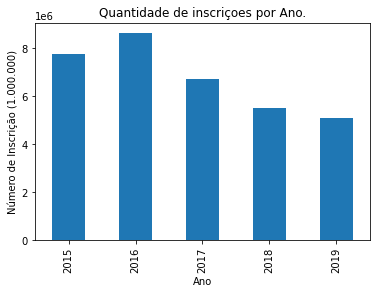

In [98]:
# Realização da Análise Exploratória

print('Quantidade de inscriçoes por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

# Apresentando os valores da consulta SQL no Spark
sqlContext.sql('SELECT NU_ANO AS ANO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO ORDER BY NU_ANO, COUNT(*)').show( )

# Criação do dataframe com os valores selecionados
df_grafico = sqlContext.sql('SELECT NU_ANO AS ANO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO ORDER BY NU_ANO, COUNT(*)').toPandas()

# Apresentando o grafico do Dataframe df_grafico.
df_grafico.plot(kind='bar', x='ANO', y='QTDE_INSCRICAO', legend=False)
plt.title('Quantidade de inscriçoes por Ano.')
plt.xlabel('Ano',)
plt.ylabel('Número de Inscrição (1.000.000)')

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Sexo.

Consulta inciada -  2020-09-02 18:21:03.123301
+---------+--------------+----------+
|     SEXO|QTDE_INSCRICAO|PERCENTUAL|
+---------+--------------+----------+
| Feminino|      19679368|     58.37|
|Masculino|      14034784|     41.63|
+---------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 18:27:13.114729


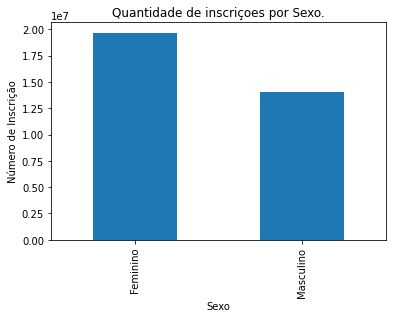

In [99]:
print('Quantidade de inscriçoes por Sexo.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

# Apresentando os valores da consulta SQL no Spark
sqlContext.sql('SELECT SEXO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY SEXO ORDER BY COUNT(*) DESC').show()

# Criação do dataframe com os valores selecionados
df_grafico = sqlContext.sql('SELECT SEXO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY SEXO ORDER BY COUNT(*) DESC').toPandas()

# Apresentando o grafico do Dataframe df_grafico.
df_grafico.plot(kind='bar', x='SEXO', y='QTDE_INSCRICAO', legend=False)
plt.title('Quantidade de inscriçoes por Sexo.')
plt.xlabel('Sexo')
plt.ylabel('Número de Inscrição')

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Sexo por Ano.

Consulta inciada -  2020-09-02 18:27:13.456816
+----+---------+--------------+----------+
| ANO|     SEXO|QTDE_INSCRICAO|PERCENTUAL|
+----+---------+--------------+----------+
|2015| Feminino|       4460448|     13.23|
|2015|Masculino|       3285979|      9.75|
|2016| Feminino|       4982639|     14.78|
|2016|Masculino|       3644728|     10.81|
|2017| Feminino|       3946756|     11.71|
|2017|Masculino|       2784585|      8.26|
|2018| Feminino|       3257703|      9.66|
|2018|Masculino|       2256044|      6.69|
|2019| Feminino|       3031822|      8.99|
|2019|Masculino|       2063448|      6.12|
+----+---------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 18:33:30.430419


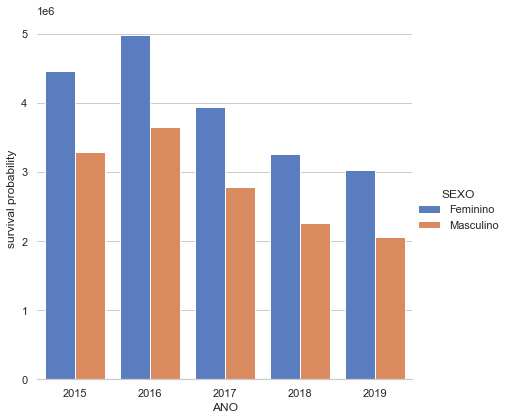

In [100]:
print('Quantidade de inscriçoes por Sexo por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

# Apresentando os valores da consulta SQL no Spark
sqlContext.sql('SELECT NU_ANO AS ANO, SEXO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, SEXO ORDER BY NU_ANO, COUNT(*) DESC').show()

# Criação do dataframe com os valores selecionados
df_grafico = sqlContext.sql('SELECT NU_ANO AS ANO, SEXO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, SEXO ORDER BY NU_ANO, COUNT(*) DESC').toPandas()

# Apresentando o grafico do Dataframe df_grafico.
sns.set(style="whitegrid")

g = sns.catplot(x="ANO", y="QTDE_INSCRICAO", hue="SEXO", data=df_grafico, height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Estado Civil.

Consulta inciada -  2020-09-02 18:33:30.765523
+---------------------------------------+--------------+----------+
|ESTADO_CIVIL                           |QTDE_INSCRICAO|PERCENTUAL|
+---------------------------------------+--------------+----------+
|Solteiro                               |24197550      |71.77     |
|Casado(a)/Mora com companheiro(a)      |7350094       |21.8      |
|                                       |1199287       |3.56      |
|Divorciado(a)/Desquitado(a)/Separado(a)|829816        |2.46      |
|Viúvo(a)                               |137405        |0.41      |
+---------------------------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 18:39:43.829132


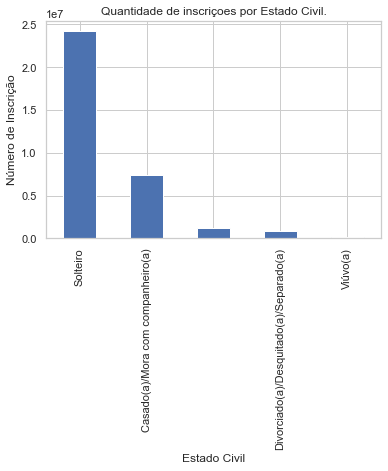

In [101]:
print('Quantidade de inscriçoes por Estado Civil.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

# Apresentando os valores da consulta SQL no Spark
sqlContext.sql('SELECT ESTADO_CIVIL, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY ESTADO_CIVIL ORDER BY COUNT(*) DESC').show(truncate = False)

# Criação do dataframe com os valores selecionados
df_grafico = sqlContext.sql('SELECT ESTADO_CIVIL, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY ESTADO_CIVIL ORDER BY COUNT(*) DESC').toPandas()

# Apresentando o grafico do Dataframe df_grafico.
df_grafico.plot(kind='bar', x='ESTADO_CIVIL', y='QTDE_INSCRICAO', legend=False)
plt.title('Quantidade de inscriçoes por Estado Civil.')
plt.xlabel('Estado Civil',)
plt.ylabel('Número de Inscrição')

print(f'Consulta realizada com sucesso -  {datetime.now()}')

In [102]:
print('Quantidade de inscriçoes por Estado Civil por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, ESTADO_CIVIL, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, ESTADO_CIVIL ORDER BY NU_ANO, COUNT(*) DESC').show(30, truncate = False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Estado Civil por Ano.

Consulta inciada -  2020-09-02 18:39:44.137977
+----+---------------------------------------+--------------+----------+
|ANO |ESTADO_CIVIL                           |QTDE_INSCRICAO|PERCENTUAL|
+----+---------------------------------------+--------------+----------+
|2015|Solteiro                               |6417079       |19.03     |
|2015|Casado(a)/Mora com companheiro(a)      |866112        |2.57      |
|2015|                                       |323232        |0.96      |
|2015|Divorciado(a)/Desquitado(a)/Separado(a)|124427        |0.37      |
|2015|Viúvo(a)                               |15577         |0.05      |
|2016|Solteiro                               |7144455       |21.19     |
|2016|Casado(a)/Mora com companheiro(a)      |947502        |2.81      |
|2016|                                       |380541        |1.13      |
|2016|Divorciado(a)/Desquitado(a)/Separado(a)|138765        |0.41      |
|2016|Viúvo(a)           

In [103]:
print('Quantidade de inscriçoes por Raça.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT RACA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY RACA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Raça.

Consulta inciada -  2020-09-02 18:42:51.893907
+-------------+--------------+----------+
|         RACA|QTDE_INSCRICAO|PERCENTUAL|
+-------------+--------------+----------+
|        Parda|      15612687|     46.31|
|       Branca|      12059987|     35.77|
|        Preta|       4411602|     13.09|
|      Amarela|        766447|      2.27|
|Não declarado|        634299|      1.88|
|    Indígena |        208649|      0.62|
|             |         20481|      0.06|
+-------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 18:45:52.525893


In [104]:
print('Quantidade de inscriçoes por Raça por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, RACA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, RACA ORDER BY NU_ANO, COUNT(*) DESC').show(40)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Raça por Ano.

Consulta inciada -  2020-09-02 18:45:52.544842
+----+-------------+--------------+----------+
| ANO|         RACA|QTDE_INSCRICAO|PERCENTUAL|
+----+-------------+--------------+----------+
|2015|        Parda|       3528864|     10.47|
|2015|       Branca|       2843817|      8.44|
|2015|        Preta|       1013917|      3.01|
|2015|      Amarela|        170228|       0.5|
|2015|Não declarado|        124527|      0.37|
|2015|    Indígena |         44806|      0.13|
|2015|             |         20268|      0.06|
|2016|        Parda|       4003922|     11.88|
|2016|       Branca|       3047482|      9.04|
|2016|        Preta|       1155766|      3.43|
|2016|      Amarela|        201102|       0.6|
|2016|Não declarado|        164629|      0.49|
|2016|    Indígena |         54253|      0.16|
|2016|             |           213|       0.0|
|2017|        Parda|       3154520|      9.36|
|2017|       Branca|       2355252|      6.99|
|2017|        Pr

In [105]:
print('Quantidade de inscriçoes por Nacionalidade.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NACIONALIDADE, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NACIONALIDADE ORDER BY COUNT(*) DESC').show(truncate = False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Nacionalidade.

Consulta inciada -  2020-09-02 18:48:58.115233
+---------------------------------------------+--------------+----------+
|NACIONALIDADE                                |QTDE_INSCRICAO|PERCENTUAL|
+---------------------------------------------+--------------+----------+
|Brasileiro(a)                                |32435187      |96.21     |
|Brasileiro(a) Naturalizado(a)                |1135510       |3.37      |
|Brasileiro(a) Nato(a), nascido(a) no exterior|85678         |0.25      |
|Estrangeiro(a)                               |40436         |0.12      |
|Não informado                                |17341         |0.05      |
+---------------------------------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 18:52:11.152630


In [106]:
print('Quantidade de inscriçoes por Nacionalidade por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, NACIONALIDADE, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, NACIONALIDADE ORDER BY NU_ANO, COUNT(*) DESC').show(30, truncate = False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Nacionalidade por Ano.

Consulta inciada -  2020-09-02 18:52:11.172577
+----+---------------------------------------------+----------+
|ANO |NACIONALIDADE                                |PERCENTUAL|
+----+---------------------------------------------+----------+
|2015|Brasileiro(a)                                |22.04     |
|2015|Brasileiro(a) Naturalizado(a)                |0.83      |
|2015|Brasileiro(a) Nato(a), nascido(a) no exterior|0.07      |
|2015|Estrangeiro(a)                               |0.03      |
|2015|Não informado                                |0.01      |
|2016|Brasileiro(a)                                |24.4      |
|2016|Brasileiro(a) Naturalizado(a)                |1.08      |
|2016|Brasileiro(a) Nato(a), nascido(a) no exterior|0.07      |
|2016|Estrangeiro(a)                               |0.03      |
|2016|Não informado                                |0.01      |
|2017|Brasileiro(a)                                |19.28     |
|201

In [107]:
print('Quantidade de inscriçoes por Situação Conclusão Ensino Médio.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT SITUACAO_CONCLUSAO_ENSINO_MEDIO, COUNT(* ) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY SITUACAO_CONCLUSAO_ENSINO_MEDIO ORDER BY COUNT(*) DESC').show(truncate = False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Situação Conclusão Ensino Médio.

Consulta inciada -  2020-09-02 18:55:14.923852
+--------------------------------------------------------+--------------+----------+
|SITUACAO_CONCLUSAO_ENSINO_MEDIO                         |QTDE_INSCRICAO|PERCENTUAL|
+--------------------------------------------------------+--------------+----------+
|Já concluí o Ensino Médio                               |19919399      |59.08     |
|Estou cursando e concluirei o Ensino Médio no ano       |8424851       |24.99     |
|Estou cursando e concluirei o Ensino Médio após este ano|4302929       |12.76     |
|Não concluí e não estou cursando o Ensino Médio         |1066973       |3.16      |
+--------------------------------------------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 18:58:23.965423


In [108]:
print('Quantidade de inscriçoes por Situação Conclusão Ensino Médio por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, SITUACAO_CONCLUSAO_ENSINO_MEDIO, COUNT(* ) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, SITUACAO_CONCLUSAO_ENSINO_MEDIO ORDER BY NU_ANO, COUNT(*) DESC').show(truncate = False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Situação Conclusão Ensino Médio por Ano.

Consulta inciada -  2020-09-02 18:58:23.990355
+----+--------------------------------------------------------+--------------+----------+
|ANO |SITUACAO_CONCLUSAO_ENSINO_MEDIO                         |QTDE_INSCRICAO|PERCENTUAL|
+----+--------------------------------------------------------+--------------+----------+
|2015|Já concluí o Ensino Médio                               |4492044       |13.32     |
|2015|Estou cursando e concluirei o Ensino Médio no ano       |1649860       |4.89      |
|2015|Estou cursando e concluirei o Ensino Médio após este ano|1157560       |3.43      |
|2015|Não concluí e não estou cursando o Ensino Médio         |446963        |1.33      |
|2016|Já concluí o Ensino Médio                               |4928251       |14.62     |
|2016|Estou cursando e concluirei o Ensino Médio no ano       |1882278       |5.58      |
|2016|Estou cursando e concluirei o Ensino Médio após este ano|1344085  

In [109]:
print('Quantidade de inscriçoes por Tipo Escola.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT TIPO_ESCOLA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY TIPO_ESCOLA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Tipo Escola.

Consulta inciada -  2020-09-02 19:01:31.829567
+-------------+--------------+----------+
|  TIPO_ESCOLA|QTDE_INSCRICAO|PERCENTUAL|
+-------------+--------------+----------+
|Não Respondeu|      25526429|     75.71|
|      Pública|       6780145|     20.11|
|      Privada|       1149757|      3.41|
|     Exterior|        257821|      0.76|
+-------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 19:04:34.076514


In [110]:
print('Quantidade de inscriçoes por Tipo Escola por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, TIPO_ESCOLA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, TIPO_ESCOLA ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Tipo Escola por Ano.

Consulta inciada -  2020-09-02 19:04:34.107430
+----+-------------+--------------+----------+
| ANO|  TIPO_ESCOLA|QTDE_INSCRICAO|PERCENTUAL|
+----+-------------+--------------+----------+
|2015|Não Respondeu|       6096567|     18.08|
|2015|      Pública|       1344863|      3.99|
|2015|      Privada|        304372|       0.9|
|2015|     Exterior|           625|       0.0|
|2016|Não Respondeu|       6745091|     20.01|
|2016|      Pública|       1561876|      4.63|
|2016|      Privada|        319415|      0.95|
|2016|     Exterior|           985|       0.0|
|2017|Não Respondeu|       4944631|     14.67|
|2017|      Pública|       1488653|      4.42|
|2017|      Privada|        293461|      0.87|
|2017|     Exterior|          4596|      0.01|
|2018|Não Respondeu|       4110764|     12.19|
|2018|      Pública|       1137491|      3.37|
|2018|     Exterior|        251615|      0.75|
|2018|      Privada|         13877|      0.04|
|2019|Não

In [111]:
print('Quantidade de inscriçoes por Tipo Ensino.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT TIPO_ENSINO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY TIPO_ENSINO ORDER BY COUNT(*) DESC').show(truncate = False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Tipo Ensino.

Consulta inciada -  2020-09-02 19:07:41.878097
+-------------------------------------------+--------------+----------+
|TIPO_ENSINO                                |QTDE_INSCRICAO|PERCENTUAL|
+-------------------------------------------+--------------+----------+
|                                           |22036422      |65.36     |
|Ensino Regular                             |10700506      |31.74     |
|Educação de Jovens e Adultos               |917342        |2.72      |
|Educação Especial - Modalidade Substitutiva|59882         |0.18      |
+-------------------------------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 19:10:48.129286


In [112]:
print('Quantidade de inscriçoes por Tipo Ensino por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, TIPO_ENSINO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, TIPO_ENSINO ORDER BY NU_ANO, COUNT(*) DESC').show(truncate = False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Tipo Ensino por Ano.

Consulta inciada -  2020-09-02 19:10:48.165191
+----+-------------------------------------------+--------------+----------+
|ANO |TIPO_ENSINO                                |QTDE_INSCRICAO|PERCENTUAL|
+----+-------------------------------------------+--------------+----------+
|2015|                                           |6097192       |18.08     |
|2015|Ensino Regular                             |1470357       |4.36      |
|2015|Educação de Jovens e Adultos               |169509        |0.5       |
|2015|Educação Especial - Modalidade Substitutiva|9369          |0.03      |
|2016|                                           |6746055       |20.01     |
|2016|Ensino Regular                             |1652485       |4.9       |
|2016|Educação de Jovens e Adultos               |218532        |0.65      |
|2016|Educação Especial - Modalidade Substitutiva|10295         |0.03      |
|2017|                                           |49454

In [113]:
print('Quantidade de inscriçoes por Treineiro.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT TREINEIRO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY TREINEIRO ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Treineiro.

Consulta inciada -  2020-09-02 19:13:52.157219
+---------+--------------+----------+
|TREINEIRO|QTDE_INSCRICAO|PERCENTUAL|
+---------+--------------+----------+
|      Não|      30127568|     89.36|
|      Sim|       3586584|     10.64|
+---------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 19:16:59.786178


In [114]:
print('Quantidade de inscriçoes por Treineiro por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, TREINEIRO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, TREINEIRO ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Treineiro por Ano.

Consulta inciada -  2020-09-02 19:16:59.804130
+----+---------+--------------+----------+
| ANO|TREINEIRO|QTDE_INSCRICAO|PERCENTUAL|
+----+---------+--------------+----------+
|2015|      Não|       6840001|     20.29|
|2015|      Sim|        906426|      2.69|
|2016|      Não|       7608438|     22.57|
|2016|      Sim|       1018929|      3.02|
|2017|      Não|       6214489|     18.43|
|2017|      Sim|        516852|      1.53|
|2018|      Não|       4986038|     14.79|
|2018|      Sim|        527709|      1.57|
|2019|      Não|       4478602|     13.28|
|2019|      Sim|        616668|      1.83|
+----+---------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 19:20:04.465133


In [115]:
print('Quantidade de inscriçoes por Dependência Administrativa Escola.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT DEPENDENCIA_ADMINISTRATIVA_ESCOLA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY DEPENDENCIA_ADMINISTRATIVA_ESCOLA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Dependência Administrativa Escola.

Consulta inciada -  2020-09-02 19:20:04.491065
+---------------------------------+--------------+----------+
|DEPENDENCIA_ADMINISTRATIVA_ESCOLA|QTDE_INSCRICAO|PERCENTUAL|
+---------------------------------+--------------+----------+
|                                 |      25801465|     76.53|
|                         Estadual|       6280273|     18.63|
|                          Privada|       1337142|      3.97|
|                          Federal|        212646|      0.63|
|                        Municipal|         82626|      0.25|
+---------------------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 19:23:08.068624


In [116]:
print('Quantidade de inscriçoes por Dependência Administrativa Escola por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, DEPENDENCIA_ADMINISTRATIVA_ESCOLA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, DEPENDENCIA_ADMINISTRATIVA_ESCOLA ORDER BY NU_ANO, COUNT(*) DESC').show(30)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Dependência Administrativa Escola por Ano.

Consulta inciada -  2020-09-02 19:23:08.090566
+----+---------------------------------+--------------+----------+
| ANO|DEPENDENCIA_ADMINISTRATIVA_ESCOLA|QTDE_INSCRICAO|PERCENTUAL|
+----+---------------------------------+--------------+----------+
|2015|                                 |       6097169|     18.08|
|2015|                         Estadual|       1293573|      3.84|
|2015|                          Privada|        304364|       0.9|
|2015|                          Federal|         34192|       0.1|
|2015|                        Municipal|         17129|      0.05|
|2016|                                 |       6746085|     20.01|
|2016|                         Estadual|       1501527|      4.45|
|2016|                          Privada|        319380|      0.95|
|2016|                          Federal|         38741|      0.11|
|2016|                        Municipal|         21634|      0.06|
|2017|   

In [117]:
print('Quantidade de inscriçoes por Localização Escola.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT LOCALIZACAO_ESCOLA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY LOCALIZACAO_ESCOLA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Localização Escola.

Consulta inciada -  2020-09-02 19:26:14.794827
+------------------+--------------+----------+
|LOCALIZACAO_ESCOLA|QTDE_INSCRICAO|PERCENTUAL|
+------------------+--------------+----------+
|                  |      25801465|     76.53|
|            Urbana|       7665166|     22.74|
|             Rural|        247521|      0.73|
+------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 19:29:19.271969


In [118]:
print('Quantidade de inscriçoes por Localização Escola por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, LOCALIZACAO_ESCOLA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, LOCALIZACAO_ESCOLA ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Localização Escola por Ano.

Consulta inciada -  2020-09-02 19:29:19.289920
+----+------------------+--------------+----------+
| ANO|LOCALIZACAO_ESCOLA|QTDE_INSCRICAO|PERCENTUAL|
+----+------------------+--------------+----------+
|2015|                  |       6097169|     18.08|
|2015|            Urbana|       1602743|      4.75|
|2015|             Rural|         46515|      0.14|
|2016|                  |       6746085|     20.01|
|2016|            Urbana|       1827543|      5.42|
|2016|             Rural|         53739|      0.16|
|2017|                  |       4945427|     14.67|
|2017|            Urbana|       1729579|      5.13|
|2017|             Rural|         56335|      0.17|
|2018|                  |       4064926|     12.06|
|2018|            Urbana|       1399430|      4.15|
|2018|             Rural|         49391|      0.15|
|2019|                  |       3947858|     11.71|
|2019|            Urbana|       1105871|      3.28|
|2019|     

In [119]:
print('Quantidade de inscriçoes por Baixa Visão.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT BAIXA_VISAO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY BAIXA_VISAO ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Baixa Visão.

Consulta inciada -  2020-09-02 19:32:22.987142
+-----------+--------------+----------+
|BAIXA_VISAO|QTDE_INSCRICAO|PERCENTUAL|
+-----------+--------------+----------+
|        Não|      33673697|     99.88|
|        Sim|         40455|      0.12|
+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 19:35:27.938353


In [120]:
print('Quantidade de inscriçoes por Baixa Visão por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, BAIXA_VISAO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, BAIXA_VISAO ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Baixa Visão por Ano.

Consulta inciada -  2020-09-02 19:35:27.966278
+----+-----------+--------------+----------+
| ANO|BAIXA_VISAO|QTDE_INSCRICAO|PERCENTUAL|
+----+-----------+--------------+----------+
|2015|        Não|       7736290|     22.95|
|2015|        Sim|         10137|      0.03|
|2016|        Não|       8615808|     25.56|
|2016|        Sim|         11559|      0.03|
|2017|        Não|       6724034|     19.94|
|2017|        Sim|          7307|      0.02|
|2018|        Não|       5508496|     16.34|
|2018|        Sim|          5251|      0.02|
|2019|        Não|       5089069|     15.09|
|2019|        Sim|          6201|      0.02|
+----+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 19:38:31.610295


In [121]:
print('Quantidade de inscriçoes por Cegueira.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT CEGUEIRA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY CEGUEIRA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Cegueira.

Consulta inciada -  2020-09-02 19:38:31.629243
+--------+--------------+----------+
|CEGUEIRA|QTDE_INSCRICAO|PERCENTUAL|
+--------+--------------+----------+
|     Não|      33709598|     99.99|
|     Sim|          4554|      0.01|
+--------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 19:41:36.602674


In [122]:
print('Quantidade de inscriçoes por Cegueira por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, CEGUEIRA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, CEGUEIRA ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Cegueira por Ano.

Consulta inciada -  2020-09-02 19:41:36.626610
+----+--------+--------------+----------+
| ANO|CEGUEIRA|QTDE_INSCRICAO|PERCENTUAL|
+----+--------+--------------+----------+
|2015|     Não|       7745386|     22.97|
|2015|     Sim|          1041|       0.0|
|2016|     Não|       8626211|     25.59|
|2016|     Sim|          1156|       0.0|
|2017|     Não|       6730457|     19.96|
|2017|     Sim|           884|       0.0|
|2018|     Não|       5512989|     16.35|
|2018|     Sim|           758|       0.0|
|2019|     Não|       5094555|     15.11|
|2019|     Sim|           715|       0.0|
+----+--------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 19:44:43.597011


In [123]:
print('Quantidade de inscriçoes por Surdez.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT SURDEZ, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY SURDEZ ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Surdez.

Consulta inciada -  2020-09-02 19:44:43.613965
+------+--------------+----------+
|SURDEZ|QTDE_INSCRICAO|PERCENTUAL|
+------+--------------+----------+
|   Não|      33705038|     99.97|
|   Sim|          9114|      0.03|
+------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 19:47:47.524876


In [124]:
print('Quantidade de inscriçoes por Surdez por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, SURDEZ, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, SURDEZ ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Surdez por Ano.

Consulta inciada -  2020-09-02 19:47:47.553800
+----+------+--------------+----------+
| ANO|SURDEZ|QTDE_INSCRICAO|PERCENTUAL|
+----+------+--------------+----------+
|2015|   Não|       7744597|     22.97|
|2015|   Sim|          1830|      0.01|
|2016|   Não|       8625076|     25.58|
|2016|   Sim|          2291|      0.01|
|2017|   Não|       6729416|     19.96|
|2017|   Sim|          1925|      0.01|
|2018|   Não|       5512302|     16.35|
|2018|   Sim|          1445|       0.0|
|2019|   Não|       5093647|     15.11|
|2019|   Sim|          1623|       0.0|
+----+------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 19:50:51.754849


In [125]:
print('Quantidade de inscriçoes por Deficiência Auditiva.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT DEFICIENCIA_AUDITIVA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY DEFICIENCIA_AUDITIVA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Deficiência Auditiva.

Consulta inciada -  2020-09-02 19:50:51.776789
+--------------------+--------------+----------+
|DEFICIENCIA_AUDITIVA|QTDE_INSCRICAO|PERCENTUAL|
+--------------------+--------------+----------+
|                 Não|      33691704|     99.93|
|                 Sim|         22448|      0.07|
+--------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 19:53:55.817269


In [126]:
print('Quantidade de inscriçoes por Deficiência Auditiva por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, DEFICIENCIA_AUDITIVA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, DEFICIENCIA_AUDITIVA ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Deficiência Auditiva por Ano.

Consulta inciada -  2020-09-02 19:53:55.846193
+----+--------------------+--------------+----------+
| ANO|DEFICIENCIA_AUDITIVA|QTDE_INSCRICAO|PERCENTUAL|
+----+--------------------+--------------+----------+
|2015|                 Não|       7740119|     22.96|
|2015|                 Sim|          6308|      0.02|
|2016|                 Não|       8620236|     25.57|
|2016|                 Sim|          7131|      0.02|
|2017|                 Não|       6726951|     19.95|
|2017|                 Sim|          4390|      0.01|
|2018|                 Não|       5511331|     16.35|
|2018|                 Sim|          2416|      0.01|
|2019|                 Não|       5093067|     15.11|
|2019|                 Sim|          2203|      0.01|
+----+--------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 19:57:03.134662


In [127]:
print('Quantidade de inscriçoes por Surdo_Cegueira.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT SURDO_CEGUEIRA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY SURDO_CEGUEIRA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Surdo_Cegueira.

Consulta inciada -  2020-09-02 19:57:03.165581
+--------------+--------------+----------+
|SURDO_CEGUEIRA|QTDE_INSCRICAO|PERCENTUAL|
+--------------+--------------+----------+
|           Não|      33714026|     100.0|
|           Sim|           126|       0.0|
+--------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:00:07.572955


In [128]:
print('Quantidade de inscriçoes por Surdo_Cegueira por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, SURDO_CEGUEIRA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, SURDO_CEGUEIRA ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Surdo_Cegueira por Ano.

Consulta inciada -  2020-09-02 20:00:07.598885
+----+--------------+--------------+----------+
| ANO|SURDO_CEGUEIRA|QTDE_INSCRICAO|PERCENTUAL|
+----+--------------+--------------+----------+
|2015|           Não|       7746405|     22.98|
|2015|           Sim|            22|       0.0|
|2016|           Não|       8627344|     25.59|
|2016|           Sim|            23|       0.0|
|2017|           Não|       6731320|     19.97|
|2017|           Sim|            21|       0.0|
|2018|           Não|       5513734|     16.35|
|2018|           Sim|            13|       0.0|
|2019|           Não|       5095223|     15.11|
|2019|           Sim|            47|       0.0|
+----+--------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:03:12.674015


In [129]:
print('Quantidade de inscriçoes por Deficiência Física.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT DEFICIENCIA_FISICA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY DEFICIENCIA_FISICA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Deficiência Física.

Consulta inciada -  2020-09-02 20:03:12.700943
+------------------+--------------+----------+
|DEFICIENCIA_FISICA|QTDE_INSCRICAO|PERCENTUAL|
+------------------+--------------+----------+
|               Não|      33643894|     99.79|
|               Sim|         70258|      0.21|
+------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:06:17.534043


In [130]:
print('Quantidade de inscriçoes por Deficiência Física por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, DEFICIENCIA_FISICA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, DEFICIENCIA_FISICA ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Deficiência Física por Ano.

Consulta inciada -  2020-09-02 20:06:17.553991
+----+------------------+--------------+----------+
| ANO|DEFICIENCIA_FISICA|QTDE_INSCRICAO|PERCENTUAL|
+----+------------------+--------------+----------+
|2015|               Não|       7727373|     22.92|
|2015|               Sim|         19054|      0.06|
|2016|               Não|       8604998|     25.52|
|2016|               Sim|         22369|      0.07|
|2017|               Não|       6718917|     19.93|
|2017|               Sim|         12424|      0.04|
|2018|               Não|       5504818|     16.33|
|2018|               Sim|          8929|      0.03|
|2019|               Não|       5087788|     15.09|
|2019|               Sim|          7482|      0.02|
+----+------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:09:21.225487


In [131]:
print('Quantidade de inscriçoes por Deficiência Mental.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT DEFICIENCIA_MENTAL, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY DEFICIENCIA_MENTAL ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Deficiência Mental.

Consulta inciada -  2020-09-02 20:09:21.255409
+------------------+--------------+----------+
|DEFICIENCIA_MENTAL|QTDE_INSCRICAO|PERCENTUAL|
+------------------+--------------+----------+
|               Não|      33704239|     99.97|
|               Sim|          9913|      0.03|
+------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:12:25.614642


In [132]:
print('Quantidade de inscriçoes por Deficiência Mental por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, DEFICIENCIA_MENTAL, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, DEFICIENCIA_MENTAL ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Deficiência Mental por Ano.

Consulta inciada -  2020-09-02 20:12:25.640573
+----+------------------+--------------+----------+
| ANO|DEFICIENCIA_MENTAL|QTDE_INSCRICAO|PERCENTUAL|
+----+------------------+--------------+----------+
|2015|               Não|       7744235|     22.97|
|2015|               Sim|          2192|      0.01|
|2016|               Não|       8626259|     25.59|
|2016|               Sim|          1108|       0.0|
|2017|               Não|       6728929|     19.96|
|2017|               Sim|          2412|      0.01|
|2018|               Não|       5511794|     16.35|
|2018|               Sim|          1953|      0.01|
|2019|               Não|       5093022|     15.11|
|2019|               Sim|          2248|      0.01|
+----+------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:15:27.670696


In [133]:
print('Quantidade de inscriçoes por Deficit de Atenção.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT DEFICIT_ATENCAO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY DEFICIT_ATENCAO ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Deficit de Atenção.

Consulta inciada -  2020-09-02 20:15:27.690643
+---------------+--------------+----------+
|DEFICIT_ATENCAO|QTDE_INSCRICAO|PERCENTUAL|
+---------------+--------------+----------+
|            Não|      33681678|      99.9|
|            Sim|         32474|       0.1|
+---------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:18:37.660405


In [134]:
print('Quantidade de inscriçoes por Deficit de Atenção por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, DEFICIT_ATENCAO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, DEFICIT_ATENCAO ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Deficit de Atenção por Ano.

Consulta inciada -  2020-09-02 20:18:37.686334
+----+---------------+--------------+----------+
| ANO|DEFICIT_ATENCAO|QTDE_INSCRICAO|PERCENTUAL|
+----+---------------+--------------+----------+
|2015|            Não|       7742579|     22.97|
|2015|            Sim|          3848|      0.01|
|2016|            Não|       8622067|     25.57|
|2016|            Sim|          5300|      0.02|
|2017|            Não|       6723552|     19.94|
|2017|            Sim|          7789|      0.02|
|2018|            Não|       5506548|     16.33|
|2018|            Sim|          7199|      0.02|
|2019|            Não|       5086932|     15.09|
|2019|            Sim|          8338|      0.02|
+----+---------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:21:40.479162


In [135]:
print('Quantidade de inscriçoes por Dislexia.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT DISLEXIA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY DISLEXIA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Dislexia.

Consulta inciada -  2020-09-02 20:21:40.507127
+--------+--------------+----------+
|DISLEXIA|QTDE_INSCRICAO|PERCENTUAL|
+--------+--------------+----------+
|     Não|      33707202|     99.98|
|     Sim|          6950|      0.02|
+--------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:24:43.415834


In [136]:
print('Quantidade de inscriçoes por Dislexia por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, DISLEXIA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, DISLEXIA ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Dislexia por Ano.

Consulta inciada -  2020-09-02 20:24:43.430793
+----+--------+--------------+----------+
| ANO|DISLEXIA|QTDE_INSCRICAO|PERCENTUAL|
+----+--------+--------------+----------+
|2015|     Não|       7745367|     22.97|
|2015|     Sim|          1060|       0.0|
|2016|     Não|       8625928|     25.59|
|2016|     Sim|          1439|       0.0|
|2017|     Não|       6729904|     19.96|
|2017|     Sim|          1437|       0.0|
|2018|     Não|       5512329|     16.35|
|2018|     Sim|          1418|       0.0|
|2019|     Não|       5093674|     15.11|
|2019|     Sim|          1596|       0.0|
+----+--------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:27:48.556669


In [137]:
print('Quantidade de inscriçoes por Discalculia.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT DISCALCULIA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY DISCALCULIA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Discalculia.

Consulta inciada -  2020-09-02 20:27:48.583598
+-----------+--------------+----------+
|DISCALCULIA|QTDE_INSCRICAO|PERCENTUAL|
+-----------+--------------+----------+
|        Não|      33712676|     100.0|
|        Sim|          1476|       0.0|
+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:30:55.340323


In [138]:
print('Quantidade de inscriçoes por Discalculia por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, DISCALCULIA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, DISCALCULIA ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Discalculia por Ano.

Consulta inciada -  2020-09-02 20:30:55.360269
+----+-----------+--------------+----------+
| ANO|DISCALCULIA|QTDE_INSCRICAO|PERCENTUAL|
+----+-----------+--------------+----------+
|2015|        Não|       7746248|     22.98|
|2015|        Sim|           179|       0.0|
|2016|        Não|       8627025|     25.59|
|2016|        Sim|           342|       0.0|
|2017|        Não|       6731068|     19.97|
|2017|        Sim|           273|       0.0|
|2018|        Não|       5513447|     16.35|
|2018|        Sim|           300|       0.0|
|2019|        Não|       5094888|     15.11|
|2019|        Sim|           382|       0.0|
+----+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:33:57.220575


In [139]:
print('Quantidade de inscriçoes por Autismo.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT AUTISMO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY AUTISMO ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Autismo.

Consulta inciada -  2020-09-02 20:33:57.235536
+-------+--------------+----------+
|AUTISMO|QTDE_INSCRICAO|PERCENTUAL|
+-------+--------------+----------+
|    Não|      33710842|     99.99|
|    Sim|          3310|      0.01|
+-------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:37:04.556040


In [140]:
print('Quantidade de inscriçoes por Autismo por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, AUTISMO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, AUTISMO ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Autismo por Ano.

Consulta inciada -  2020-09-02 20:37:04.574991
+----+-------+--------------+----------+
| ANO|AUTISMO|QTDE_INSCRICAO|PERCENTUAL|
+----+-------+--------------+----------+
|2015|    Não|       7746171|     22.98|
|2015|    Sim|           256|       0.0|
|2016|    Não|       8626995|     25.59|
|2016|    Sim|           372|       0.0|
|2017|    Não|       6730637|     19.96|
|2017|    Sim|           704|       0.0|
|2018|    Não|       5512973|     16.35|
|2018|    Sim|           774|       0.0|
|2019|    Não|       5094066|     15.11|
|2019|    Sim|          1204|       0.0|
+----+-------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:40:07.717701


In [141]:
print('Quantidade de inscriçoes por Visão Monocular.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT VISAO_MONOCULAR, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY VISAO_MONOCULAR ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Visão Monocular.

Consulta inciada -  2020-09-02 20:40:07.737647
+---------------+--------------+----------+
|VISAO_MONOCULAR|QTDE_INSCRICAO|PERCENTUAL|
+---------------+--------------+----------+
|            Não|      33703225|     99.97|
|            Sim|         10927|      0.03|
+---------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:43:11.909461


In [142]:
print('Quantidade de inscriçoes por Visão Monocular por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, VISAO_MONOCULAR, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, VISAO_MONOCULAR ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Visão Monocular por Ano.

Consulta inciada -  2020-09-02 20:43:11.934393
+----+---------------+--------------+----------+
| ANO|VISAO_MONOCULAR|QTDE_INSCRICAO|PERCENTUAL|
+----+---------------+--------------+----------+
|2015|            Não|       7743474|     22.97|
|2015|            Sim|          2953|      0.01|
|2016|            Não|       8623622|     25.58|
|2016|            Sim|          3745|      0.01|
|2017|            Não|       6729621|     19.96|
|2017|            Sim|          1720|      0.01|
|2018|            Não|       5512347|     16.35|
|2018|            Sim|          1400|       0.0|
|2019|            Não|       5094161|     15.11|
|2019|            Sim|          1109|       0.0|
+----+---------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:46:18.600022


In [143]:
print('Quantidade de inscriçoes por Outra Deficiência.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT OUTRA_DEF, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY OUTRA_DEF ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Outra Deficiência.

Consulta inciada -  2020-09-02 20:46:18.621964
+---------+--------------+----------+
|OUTRA_DEF|QTDE_INSCRICAO|PERCENTUAL|
+---------+--------------+----------+
|      Não|      33695615|     99.95|
|      Sim|         18537|      0.05|
+---------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:49:21.018948


In [144]:
print('Quantidade de inscriçoes por Outra Deficiência por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, OUTRA_DEF, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, OUTRA_DEF ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Outra Deficiência por Ano.

Consulta inciada -  2020-09-02 20:49:21.043882
+----+---------+--------------+----------+
| ANO|OUTRA_DEF|QTDE_INSCRICAO|PERCENTUAL|
+----+---------+--------------+----------+
|2015|      Não|       7745132|     22.97|
|2015|      Sim|          1295|       0.0|
|2016|      Não|       8623835|     25.58|
|2016|      Sim|          3532|      0.01|
|2017|      Não|       6725390|     19.95|
|2017|      Sim|          5951|      0.02|
|2018|      Não|       5509052|     16.34|
|2018|      Sim|          4695|      0.01|
|2019|      Não|       5092206|      15.1|
|2019|      Sim|          3064|      0.01|
+----+---------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:52:27.043737


In [145]:
print('Quantidade de inscriçoes por Gestante.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT GESTANTE, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY GESTANTE ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Gestante.

Consulta inciada -  2020-09-02 20:52:27.070665
+--------+--------------+----------+
|GESTANTE|QTDE_INSCRICAO|PERCENTUAL|
+--------+--------------+----------+
|     Não|      33693332|     99.94|
|     Sim|         20820|      0.06|
+--------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:55:32.486875


In [146]:
print('Quantidade de inscriçoes por Gestante por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, GESTANTE, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, GESTANTE ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Gestante por Ano.

Consulta inciada -  2020-09-02 20:55:32.503831
+----+--------+--------------+----------+
| ANO|GESTANTE|QTDE_INSCRICAO|PERCENTUAL|
+----+--------+--------------+----------+
|2015|     Não|       7739050|     22.95|
|2015|     Sim|          7377|      0.02|
|2016|     Não|       8619777|     25.57|
|2016|     Sim|          7590|      0.02|
|2017|     Não|       6728678|     19.96|
|2017|     Sim|          2663|      0.01|
|2018|     Não|       5511967|     16.35|
|2018|     Sim|          1780|      0.01|
|2019|     Não|       5093860|     15.11|
|2019|     Sim|          1410|       0.0|
+----+--------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 20:58:37.030603


In [147]:
print('Quantidade de inscriçoes por Lactante.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT LACTANTE, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY LACTANTE ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Lactante.

Consulta inciada -  2020-09-02 20:58:37.064540
+--------+--------------+----------+
|LACTANTE|QTDE_INSCRICAO|PERCENTUAL|
+--------+--------------+----------+
|     Não|      33671090|     99.87|
|     Sim|         43062|      0.13|
+--------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:01:41.510811


In [148]:
print('Quantidade de inscriçoes por Lactante por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, LACTANTE, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, LACTANTE ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Lactante por Ano.

Consulta inciada -  2020-09-02 21:01:41.542726
+----+--------+--------------+----------+
| ANO|LACTANTE|QTDE_INSCRICAO|PERCENTUAL|
+----+--------+--------------+----------+
|2015|     Não|       7736830|     22.95|
|2015|     Sim|          9597|      0.03|
|2016|     Não|       8610829|     25.54|
|2016|     Sim|         16538|      0.05|
|2017|     Não|       6723420|     19.94|
|2017|     Sim|          7921|      0.02|
|2018|     Não|       5508371|     16.34|
|2018|     Sim|          5376|      0.02|
|2019|     Não|       5091640|      15.1|
|2019|     Sim|          3630|      0.01|
+----+--------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:04:47.084096


In [149]:
print('Quantidade de inscriçoes por Idoso.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT IDOSO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY IDOSO ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Idoso.

Consulta inciada -  2020-09-02 21:04:47.104041
+-----+--------------+----------+
|IDOSO|QTDE_INSCRICAO|PERCENTUAL|
+-----+--------------+----------+
|  Não|      33710312|     99.99|
|  Sim|          3840|      0.01|
+-----+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:07:51.938395


In [150]:
print('Quantidade de inscriçoes por Idoso por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, IDOSO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, IDOSO ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Idoso por Ano.

Consulta inciada -  2020-09-02 21:07:51.956346
+----+-----+--------------+----------+
| ANO|IDOSO|QTDE_INSCRICAO|PERCENTUAL|
+----+-----+--------------+----------+
|2015|  Não|       7744935|     22.97|
|2015|  Sim|          1492|       0.0|
|2016|  Não|       8625912|     25.59|
|2016|  Sim|          1455|       0.0|
|2017|  Não|       6730934|     19.96|
|2017|  Sim|           407|       0.0|
|2018|  Não|       5513493|     16.35|
|2018|  Sim|           254|       0.0|
|2019|  Não|       5095038|     15.11|
|2019|  Sim|           232|       0.0|
+----+-----+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:10:55.016972


In [151]:
print('Quantidade de inscriçoes por Esuda em Classe Hospitalar.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT ESTUDA_CLASSE_HOSPITALAR, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY ESTUDA_CLASSE_HOSPITALAR ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Esuda em Classe Hospitalar.

Consulta inciada -  2020-09-02 21:10:55.030936
+------------------------+--------------+----------+
|ESTUDA_CLASSE_HOSPITALAR|QTDE_INSCRICAO|PERCENTUAL|
+------------------------+--------------+----------+
|                     Não|      33713999|     100.0|
|                     Sim|           153|       0.0|
+------------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:14:03.582175


In [152]:
print('Quantidade de inscriçoes por Esuda em Classe Hospitalar por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, ESTUDA_CLASSE_HOSPITALAR, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, ESTUDA_CLASSE_HOSPITALAR ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Esuda em Classe Hospitalar por Ano.

Consulta inciada -  2020-09-02 21:14:03.597135
+----+------------------------+--------------+----------+
| ANO|ESTUDA_CLASSE_HOSPITALAR|QTDE_INSCRICAO|PERCENTUAL|
+----+------------------------+--------------+----------+
|2015|                     Não|       7746409|     22.98|
|2015|                     Sim|            18|       0.0|
|2016|                     Não|       8627329|     25.59|
|2016|                     Sim|            38|       0.0|
|2017|                     Não|       6731301|     19.97|
|2017|                     Sim|            40|       0.0|
|2018|                     Não|       5513714|     16.35|
|2018|                     Sim|            33|       0.0|
|2019|                     Não|       5095246|     15.11|
|2019|                     Sim|            24|       0.0|
+----+------------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:17:08.653801


In [153]:
print('Quantidade de inscriçoes por Esuda em Sem Recurso.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT SEM_RECURSO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY SEM_RECURSO ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Esuda em Sem Recurso.

Consulta inciada -  2020-09-02 21:17:08.674744
+-----------+--------------+----------+
|SEM_RECURSO|QTDE_INSCRICAO|PERCENTUAL|
+-----------+--------------+----------+
|        Não|      33598836|     99.66|
|        Sim|        115316|      0.34|
+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:20:11.316157


In [154]:
print('Quantidade de inscriçoes por Esuda em Sem Recurso por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, SEM_RECURSO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, SEM_RECURSO ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Esuda em Sem Recurso por Ano.

Consulta inciada -  2020-09-02 21:20:11.336102
+----+-----------+--------------+----------+
| ANO|SEM_RECURSO|QTDE_INSCRICAO|PERCENTUAL|
+----+-----------+--------------+----------+
|2015|        Não|       7711644|     22.87|
|2015|        Sim|         34783|       0.1|
|2016|        Não|       8585635|     25.47|
|2016|        Sim|         41732|      0.12|
|2017|        Não|       6708183|      19.9|
|2017|        Sim|         23158|      0.07|
|2018|        Não|       5504232|     16.33|
|2018|        Sim|          9515|      0.03|
|2019|        Não|       5089142|     15.09|
|2019|        Sim|          6128|      0.02|
+----+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:23:18.894160


In [155]:
print('Quantidade de inscriçoes por Braille.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT BRAILLE, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY BRAILLE ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Braille.

Consulta inciada -  2020-09-02 21:23:18.919093
+-------+--------------+----------+
|BRAILLE|QTDE_INSCRICAO|PERCENTUAL|
+-------+--------------+----------+
|    Não|      33712089|     99.99|
|    Sim|          2063|      0.01|
+-------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:26:23.020041


In [156]:
print('Quantidade de inscriçoes por Braille por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, BRAILLE, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, BRAILLE ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Braille por Ano.

Consulta inciada -  2020-09-02 21:26:23.037994
+----+-------+--------------+----------+
| ANO|BRAILLE|QTDE_INSCRICAO|PERCENTUAL|
+----+-------+--------------+----------+
|2015|    Não|       7745935|     22.98|
|2015|    Sim|           492|       0.0|
|2016|    Não|       8626807|     25.59|
|2016|    Sim|           560|       0.0|
|2017|    Não|       6730980|     19.96|
|2017|    Sim|           361|       0.0|
|2018|    Não|       5513399|     16.35|
|2018|    Sim|           348|       0.0|
|2019|    Não|       5094968|     15.11|
|2019|    Sim|           302|       0.0|
+----+-------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:29:26.665958


In [157]:
print('Quantidade de inscriçoes por Ampliada 24.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT AMPLIADA_24, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY AMPLIADA_24 ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Ampliada 24.

Consulta inciada -  2020-09-02 21:29:26.689893
+-----------+--------------+----------+
|AMPLIADA_24|QTDE_INSCRICAO|PERCENTUAL|
+-----------+--------------+----------+
|        Não|      33706677|     99.98|
|        Sim|          7475|      0.02|
+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:32:34.553868


In [158]:
print('Quantidade de inscriçoes por Ampliada 24.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, AMPLIADA_24, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, AMPLIADA_24 ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Ampliada 24.

Consulta inciada -  2020-09-02 21:32:34.580797
+----+-----------+--------------+----------+
| ANO|AMPLIADA_24|QTDE_INSCRICAO|PERCENTUAL|
+----+-----------+--------------+----------+
|2015|        Não|       7744807|     22.97|
|2015|        Sim|          1620|       0.0|
|2016|        Não|       8625244|     25.58|
|2016|        Sim|          2123|      0.01|
|2017|        Não|       6729963|     19.96|
|2017|        Sim|          1378|       0.0|
|2018|        Não|       5512480|     16.35|
|2018|        Sim|          1267|       0.0|
|2019|        Não|       5094183|     15.11|
|2019|        Sim|          1087|       0.0|
+----+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:35:39.015752


In [159]:
print('Quantidade de inscriçoes por Ampliada 18.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT AMPLIADA_18, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY AMPLIADA_18 ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Ampliada 18.

Consulta inciada -  2020-09-02 21:35:39.035697
+-----------+--------------+----------+
|AMPLIADA_18|QTDE_INSCRICAO|PERCENTUAL|
+-----------+--------------+----------+
|        Não|      33687767|     99.92|
|        Sim|         26385|      0.08|
+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:38:45.985447


In [160]:
print('Quantidade de inscriçoes por Ampliada 18.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, AMPLIADA_18, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, AMPLIADA_18 ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Ampliada 18.

Consulta inciada -  2020-09-02 21:38:46.005393
+----+-----------+--------------+----------+
| ANO|AMPLIADA_18|QTDE_INSCRICAO|PERCENTUAL|
+----+-----------+--------------+----------+
|2015|        Não|       7740023|     22.96|
|2015|        Sim|          6404|      0.02|
|2016|        Não|       8620060|     25.57|
|2016|        Sim|          7307|      0.02|
|2017|        Não|       6727160|     19.95|
|2017|        Sim|          4181|      0.01|
|2018|        Não|       5509824|     16.34|
|2018|        Sim|          3923|      0.01|
|2019|        Não|       5090700|      15.1|
|2019|        Sim|          4570|      0.01|
+----+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:41:49.912777


In [161]:
print('Quantidade de inscriçoes por Ledor.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT LEDOR, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY LEDOR ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Ledor.

Consulta inciada -  2020-09-02 21:41:49.935716
+-----+--------------+----------+
|LEDOR|QTDE_INSCRICAO|PERCENTUAL|
+-----+--------------+----------+
|  Não|      33682753|     99.91|
|  Sim|         31399|      0.09|
+-----+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:44:57.667368


In [162]:
print('Quantidade de inscriçoes por Ledor por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, LEDOR, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, LEDOR ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Ledor por Ano.

Consulta inciada -  2020-09-02 21:44:57.684323
+----+-----+--------------+----------+
| ANO|LEDOR|QTDE_INSCRICAO|PERCENTUAL|
+----+-----+--------------+----------+
|2015|  Não|       7739315|     22.96|
|2015|  Sim|          7112|      0.02|
|2016|  Não|       8620272|     25.57|
|2016|  Sim|          7095|      0.02|
|2017|  Não|       6726195|     19.95|
|2017|  Sim|          5146|      0.02|
|2018|  Não|       5507975|     16.34|
|2018|  Sim|          5772|      0.02|
|2019|  Não|       5088996|     15.09|
|2019|  Sim|          6274|      0.02|
+----+-----+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:47:58.698611


In [163]:
print('Quantidade de inscriçoes por Acesso.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT ACESSO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY ACESSO ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Acesso.

Consulta inciada -  2020-09-02 21:47:58.725540
+------+--------------+----------+
|ACESSO|QTDE_INSCRICAO|PERCENTUAL|
+------+--------------+----------+
|   Não|      33653419|     99.82|
|   Sim|         60733|      0.18|
+------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:51:05.737875


In [164]:
print('Quantidade de inscriçoes por Acesso por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, ACESSO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, ACESSO ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Acesso por Ano.

Consulta inciada -  2020-09-02 21:51:05.765103
+----+------+--------------+----------+
| ANO|ACESSO|QTDE_INSCRICAO|PERCENTUAL|
+----+------+--------------+----------+
|2015|   Não|       7730673|     22.93|
|2015|   Sim|         15754|      0.05|
|2016|   Não|       8609048|     25.54|
|2016|   Sim|         18319|      0.05|
|2017|   Não|       6722078|     19.94|
|2017|   Sim|          9263|      0.03|
|2018|   Não|       5504357|     16.33|
|2018|   Sim|          9390|      0.03|
|2019|   Não|       5087263|     15.09|
|2019|   Sim|          8007|      0.02|
+----+------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:54:11.272158


In [165]:
print('Quantidade de inscriçoes por Transcrição.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT TRANSCRICAO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY TRANSCRICAO ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Transcrição.

Consulta inciada -  2020-09-02 21:54:11.295095
+-----------+--------------+----------+
|TRANSCRICAO|QTDE_INSCRICAO|PERCENTUAL|
+-----------+--------------+----------+
|        Não|      33683543|     99.91|
|        Sim|         30609|      0.09|
+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 21:57:16.790977


In [166]:
print('Quantidade de inscriçoes por Transcrição por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, TRANSCRICAO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, TRANSCRICAO ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Transcrição por Ano.

Consulta inciada -  2020-09-02 21:57:16.818478
+----+-----------+--------------+----------+
| ANO|TRANSCRICAO|QTDE_INSCRICAO|PERCENTUAL|
+----+-----------+--------------+----------+
|2015|        Não|       7739137|     22.96|
|2015|        Sim|          7290|      0.02|
|2016|        Não|       8620312|     25.57|
|2016|        Sim|          7055|      0.02|
|2017|        Não|       6726112|     19.95|
|2017|        Sim|          5229|      0.02|
|2018|        Não|       5508346|     16.34|
|2018|        Sim|          5401|      0.02|
|2019|        Não|       5089636|      15.1|
|2019|        Sim|          5634|      0.02|
+----+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:00:22.943992


In [167]:
print('Quantidade de inscriçoes por Libras.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT LIBRAS, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY LIBRAS ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Libras.

Consulta inciada -  2020-09-02 22:00:22.957954
+------+--------------+----------+
|LIBRAS|QTDE_INSCRICAO|PERCENTUAL|
+------+--------------+----------+
|   Não|      33704150|     99.97|
|   Sim|         10002|      0.03|
+------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:03:27.508236


In [168]:
print('Quantidade de inscriçoes por Libras por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, LIBRAS, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, LIBRAS ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Libras por Ano.

Consulta inciada -  2020-09-02 22:03:27.539153
+----+------+--------------+----------+
| ANO|LIBRAS|QTDE_INSCRICAO|PERCENTUAL|
+----+------+--------------+----------+
|2015|   Não|       7743413|     22.97|
|2015|   Sim|          3014|      0.01|
|2016|   Não|       8623806|     25.58|
|2016|   Sim|          3561|      0.01|
|2017|   Não|       6729982|     19.96|
|2017|   Sim|          1359|       0.0|
|2018|   Não|       5512645|     16.35|
|2018|   Sim|          1102|       0.0|
|2019|   Não|       5094304|     15.11|
|2019|   Sim|           966|       0.0|
+----+------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:06:31.818661


In [169]:
print('Quantidade de inscriçoes por Leitura Labial.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT LEITURA_LABIAL, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY LEITURA_LABIAL ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Leitura Labial.

Consulta inciada -  2020-09-02 22:06:31.841600
+--------------+--------------+----------+
|LEITURA_LABIAL|QTDE_INSCRICAO|PERCENTUAL|
+--------------+--------------+----------+
|           Não|      33708872|     99.98|
|           Sim|          5280|      0.02|
+--------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:09:34.925011


In [170]:
print('Quantidade de inscriçoes por Leitura Labial por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, LEITURA_LABIAL, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, LEITURA_LABIAL ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Leitura Labial por Ano.

Consulta inciada -  2020-09-02 22:09:34.955922
+----+--------------+--------------+----------+
| ANO|LEITURA_LABIAL|QTDE_INSCRICAO|PERCENTUAL|
+----+--------------+--------------+----------+
|2015|           Não|       7744949|     22.97|
|2015|           Sim|          1478|       0.0|
|2016|           Não|       8625743|     25.58|
|2016|           Sim|          1624|       0.0|
|2017|           Não|       6730446|     19.96|
|2017|           Sim|           895|       0.0|
|2018|           Não|       5513062|     16.35|
|2018|           Sim|           685|       0.0|
|2019|           Não|       5094672|     15.11|
|2019|           Sim|           598|       0.0|
+----+--------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:12:41.910812


In [171]:
print('Quantidade de inscriçoes por Mesa Cadeira Rodas.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT MESA_CADEIRA_RODAS, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY MESA_CADEIRA_RODAS ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Mesa Cadeira Rodas.

Consulta inciada -  2020-09-02 22:12:41.932752
+------------------+--------------+----------+
|MESA_CADEIRA_RODAS|QTDE_INSCRICAO|PERCENTUAL|
+------------------+--------------+----------+
|               Não|      33702892|     99.97|
|               Sim|         11260|      0.03|
+------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:15:52.274253


In [172]:
print('Quantidade de inscriçoes por Mesa Cadeira Rodas por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, MESA_CADEIRA_RODAS, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, MESA_CADEIRA_RODAS ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Mesa Cadeira Rodas por Ano.

Consulta inciada -  2020-09-02 22:15:52.307639
+----+------------------+--------------+----------+
| ANO|MESA_CADEIRA_RODAS|QTDE_INSCRICAO|PERCENTUAL|
+----+------------------+--------------+----------+
|2015|               Não|       7743955|     22.97|
|2015|               Sim|          2472|      0.01|
|2016|               Não|       8624404|     25.58|
|2016|               Sim|          2963|      0.01|
|2017|               Não|       6729207|     19.96|
|2017|               Sim|          2134|      0.01|
|2018|               Não|       5511856|     16.35|
|2018|               Sim|          1891|      0.01|
|2019|               Não|       5093470|     15.11|
|2019|               Sim|          1800|      0.01|
+----+------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:19:01.738111


In [173]:
print('Quantidade de inscriçoes por Mesa Cadeira Separada.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT MESA_CADEIRA_SEPARADA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY MESA_CADEIRA_SEPARADA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Mesa Cadeira Separada.

Consulta inciada -  2020-09-02 22:19:01.773349
+---------------------+--------------+----------+
|MESA_CADEIRA_SEPARADA|QTDE_INSCRICAO|PERCENTUAL|
+---------------------+--------------+----------+
|                  Não|      33697178|     99.95|
|                  Sim|         16974|      0.05|
+---------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:22:15.450673


In [174]:
print('Quantidade de inscriçoes por Mesa Cadeira Separada por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, MESA_CADEIRA_SEPARADA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, MESA_CADEIRA_SEPARADA ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Mesa Cadeira Separada por Ano.

Consulta inciada -  2020-09-02 22:22:15.481219
+----+---------------------+--------------+----------+
| ANO|MESA_CADEIRA_SEPARADA|QTDE_INSCRICAO|PERCENTUAL|
+----+---------------------+--------------+----------+
|2015|                  Não|       7742194|     22.96|
|2015|                  Sim|          4233|      0.01|
|2016|                  Não|       8621456|     25.57|
|2016|                  Sim|          5911|      0.02|
|2017|                  Não|       6727879|     19.96|
|2017|                  Sim|          3462|      0.01|
|2018|                  Não|       5511805|     16.35|
|2018|                  Sim|          1942|      0.01|
|2019|                  Não|       5093844|     15.11|
|2019|                  Sim|          1426|       0.0|
+----+---------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:25:22.484234


In [175]:
print('Quantidade de inscriçoes por Apoio de Perna.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT APOIO_PERNA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY APOIO_PERNA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Apoio de Perna.

Consulta inciada -  2020-09-02 22:25:22.516610
+-----------+--------------+----------+
|APOIO_PERNA|QTDE_INSCRICAO|PERCENTUAL|
+-----------+--------------+----------+
|        Não|      33700885|     99.96|
|        Sim|         13267|      0.04|
+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:28:31.677971


In [176]:
print('Quantidade de inscriçoes por Apoio de Perna por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, APOIO_PERNA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, APOIO_PERNA ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Apoio de Perna por Ano.

Consulta inciada -  2020-09-02 22:28:31.719690
+----+-----------+--------------+----------+
| ANO|APOIO_PERNA|QTDE_INSCRICAO|PERCENTUAL|
+----+-----------+--------------+----------+
|2015|        Não|       7743254|     22.97|
|2015|        Sim|          3173|      0.01|
|2016|        Não|       8623523|     25.58|
|2016|        Sim|          3844|      0.01|
|2017|        Não|       6729429|     19.96|
|2017|        Sim|          1912|      0.01|
|2018|        Não|       5511656|     16.35|
|2018|        Sim|          2091|      0.01|
|2019|        Não|       5093023|     15.11|
|2019|        Sim|          2247|      0.01|
+----+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:31:47.260297


In [177]:
print('Quantidade de inscriçoes por Guia Iterprete.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT GUIA_INTERPRETE, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY GUIA_INTERPRETE ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Guia Iterprete.

Consulta inciada -  2020-09-02 22:31:47.295541
+---------------+--------------+----------+
|GUIA_INTERPRETE|QTDE_INSCRICAO|PERCENTUAL|
+---------------+--------------+----------+
|            Não|      33714101|     100.0|
|            Sim|            51|       0.0|
+---------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:34:56.482514


In [178]:
print('Quantidade de inscriçoes por Guia Iterprete por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, GUIA_INTERPRETE, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, GUIA_INTERPRETE ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Guia Iterprete por Ano.

Consulta inciada -  2020-09-02 22:34:56.508954
+----+---------------+--------------+----------+
| ANO|GUIA_INTERPRETE|QTDE_INSCRICAO|PERCENTUAL|
+----+---------------+--------------+----------+
|2015|            Não|       7746415|     22.98|
|2015|            Sim|            12|       0.0|
|2016|            Não|       8627352|     25.59|
|2016|            Sim|            15|       0.0|
|2017|            Não|       6731334|     19.97|
|2017|            Sim|             7|       0.0|
|2018|            Não|       5513739|     16.35|
|2018|            Sim|             8|       0.0|
|2019|            Não|       5095261|     15.11|
|2019|            Sim|             9|       0.0|
+----+---------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:38:02.850316


In [179]:
print('Quantidade de inscriçoes por Pedido de Computador.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT COMPUTADOR, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY COMPUTADOR ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Pedido de Computador.

Consulta inciada -  2020-09-02 22:38:02.870048
+----------+--------------+----------+
|COMPUTADOR|QTDE_INSCRICAO|PERCENTUAL|
+----------+--------------+----------+
|       Não|      33714118|     100.0|
|       Sim|            34|       0.0|
+----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:41:12.677181


In [180]:
print('Quantidade de inscriçoes por Pedido de Computador por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, COMPUTADOR, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, COMPUTADOR ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Pedido de Computador por Ano.

Consulta inciada -  2020-09-02 22:41:12.705735
+----+----------+--------------+----------+
| ANO|COMPUTADOR|QTDE_INSCRICAO|PERCENTUAL|
+----+----------+--------------+----------+
|2015|       Não|       7746421|     22.98|
|2015|       Sim|             6|       0.0|
|2016|       Não|       8627358|     25.59|
|2016|       Sim|             9|       0.0|
|2017|       Não|       6731338|     19.97|
|2017|       Sim|             3|       0.0|
|2018|       Não|       5513739|     16.35|
|2018|       Sim|             8|       0.0|
|2019|       Não|       5095262|     15.11|
|2019|       Sim|             8|       0.0|
+----+----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:44:16.154154


In [181]:
print('Quantidade de inscriçoes por Cadeira Especial.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT CADEIRA_ESPECIAL, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY CADEIRA_ESPECIAL ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Cadeira Especial.

Consulta inciada -  2020-09-02 22:44:16.177552
+----------------+--------------+----------+
|CADEIRA_ESPECIAL|QTDE_INSCRICAO|PERCENTUAL|
+----------------+--------------+----------+
|             Não|      33714031|     100.0|
|             Sim|           121|       0.0|
+----------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:47:26.578378


In [182]:
print('Quantidade de inscriçoes por Cadeira Especial por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, CADEIRA_ESPECIAL, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, CADEIRA_ESPECIAL ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Cadeira Especial por Ano.

Consulta inciada -  2020-09-02 22:47:26.616523
+----+----------------+--------------+----------+
| ANO|CADEIRA_ESPECIAL|QTDE_INSCRICAO|PERCENTUAL|
+----+----------------+--------------+----------+
|2015|             Não|       7746387|     22.98|
|2015|             Sim|            40|       0.0|
|2016|             Não|       8627329|     25.59|
|2016|             Sim|            38|       0.0|
|2017|             Não|       6731325|     19.97|
|2017|             Sim|            16|       0.0|
|2018|             Não|       5513733|     16.35|
|2018|             Sim|            14|       0.0|
|2019|             Não|       5095257|     15.11|
|2019|             Sim|            13|       0.0|
+----+----------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:50:45.833065


In [183]:
print('Quantidade de inscriçoes por Cadeira Canhoto.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT CADEIRA_CANHOTO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY CADEIRA_CANHOTO ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Cadeira Canhoto.

Consulta inciada -  2020-09-02 22:50:45.871686
+---------------+--------------+----------+
|CADEIRA_CANHOTO|QTDE_INSCRICAO|PERCENTUAL|
+---------------+--------------+----------+
|            Não|      33714030|     100.0|
|            Sim|           122|       0.0|
+---------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:53:52.816690


In [184]:
print('Quantidade de inscriçoes por Cadeira Canhoto por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, CADEIRA_CANHOTO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, CADEIRA_CANHOTO ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Cadeira Canhoto por Ano.

Consulta inciada -  2020-09-02 22:53:52.848183
+----+---------------+--------------+----------+
| ANO|CADEIRA_CANHOTO|QTDE_INSCRICAO|PERCENTUAL|
+----+---------------+--------------+----------+
|2015|            Não|       7746410|     22.98|
|2015|            Sim|            17|       0.0|
|2016|            Não|       8627336|     25.59|
|2016|            Sim|            31|       0.0|
|2017|            Não|       6731320|     19.97|
|2017|            Sim|            21|       0.0|
|2018|            Não|       5513708|     16.35|
|2018|            Sim|            39|       0.0|
|2019|            Não|       5095256|     15.11|
|2019|            Sim|            14|       0.0|
+----+---------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 22:57:05.779876


In [185]:
print('Quantidade de inscriçoes por Cadeira Acolchoada.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT CADEIRA_ACOLCHOADA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY CADEIRA_ACOLCHOADA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Cadeira Acolchoada.

Consulta inciada -  2020-09-02 22:57:05.810202
+------------------+--------------+----------+
|CADEIRA_ACOLCHOADA|QTDE_INSCRICAO|PERCENTUAL|
+------------------+--------------+----------+
|               Não|      33713388|     100.0|
|               Sim|           764|       0.0|
+------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:00:16.715441


In [186]:
print('Quantidade de inscriçoes por Cadeira Acolchoada por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, CADEIRA_ACOLCHOADA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, CADEIRA_ACOLCHOADA ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Cadeira Acolchoada por Ano.

Consulta inciada -  2020-09-02 23:00:16.741876
+----+------------------+--------------+----------+
| ANO|CADEIRA_ACOLCHOADA|QTDE_INSCRICAO|PERCENTUAL|
+----+------------------+--------------+----------+
|2015|               Não|       7746392|     22.98|
|2015|               Sim|            35|       0.0|
|2016|               Não|       8627085|     25.59|
|2016|               Sim|           282|       0.0|
|2017|               Não|       6731221|     19.97|
|2017|               Sim|           120|       0.0|
|2018|               Não|       5513594|     16.35|
|2018|               Sim|           153|       0.0|
|2019|               Não|       5095096|     15.11|
|2019|               Sim|           174|       0.0|
+----+------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:03:25.041078


In [187]:
print('Quantidade de inscriçoes por Prova Deitada.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT PROVA_DEITADO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY PROVA_DEITADO ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Prova Deitada.

Consulta inciada -  2020-09-02 23:03:25.069674
+-------------+--------------+----------+
|PROVA_DEITADO|QTDE_INSCRICAO|PERCENTUAL|
+-------------+--------------+----------+
|          Não|      33714131|     100.0|
|          Sim|            21|       0.0|
+-------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:06:41.843794


In [188]:
print('Quantidade de inscriçoes por Prova Deitada por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, PROVA_DEITADO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, PROVA_DEITADO ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Prova Deitada por Ano.

Consulta inciada -  2020-09-02 23:06:41.880442
+----+-------------+--------------+----------+
| ANO|PROVA_DEITADO|QTDE_INSCRICAO|PERCENTUAL|
+----+-------------+--------------+----------+
|2015|          Não|       7746422|     22.98|
|2015|          Sim|             5|       0.0|
|2016|          Não|       8627364|     25.59|
|2016|          Sim|             3|       0.0|
|2017|          Não|       6731340|     19.97|
|2017|          Sim|             1|       0.0|
|2018|          Não|       5513736|     16.35|
|2018|          Sim|            11|       0.0|
|2019|          Não|       5095269|     15.11|
|2019|          Sim|             1|       0.0|
+----+-------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:09:56.821807


In [189]:
print('Quantidade de inscriçoes por Mobiliario Obeso.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT MOBILIARIO_OBESO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY MOBILIARIO_OBESO ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Mobiliario Obeso.

Consulta inciada -  2020-09-02 23:09:56.851548
+----------------+--------------+----------+
|MOBILIARIO_OBESO|QTDE_INSCRICAO|PERCENTUAL|
+----------------+--------------+----------+
|             Não|      33713885|     100.0|
|             Sim|           267|       0.0|
+----------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:13:09.865881


In [190]:
print('Quantidade de inscriçoes por Mobiliario Obeso por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, MOBILIARIO_OBESO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, MOBILIARIO_OBESO ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Mobiliario Obeso por Ano.

Consulta inciada -  2020-09-02 23:13:09.907847
+----+----------------+--------------+----------+
| ANO|MOBILIARIO_OBESO|QTDE_INSCRICAO|PERCENTUAL|
+----+----------------+--------------+----------+
|2015|             Não|       7746395|     22.98|
|2015|             Sim|            32|       0.0|
|2016|             Não|       8627312|     25.59|
|2016|             Sim|            55|       0.0|
|2017|             Não|       6731288|     19.97|
|2017|             Sim|            53|       0.0|
|2018|             Não|       5513679|     16.35|
|2018|             Sim|            68|       0.0|
|2019|             Não|       5095211|     15.11|
|2019|             Sim|            59|       0.0|
+----+----------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:16:20.753414


In [191]:
print('Quantidade de inscriçoes por Lamina Overlay.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT LAMINA_OVERLAY, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY LAMINA_OVERLAY ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Lamina Overlay.

Consulta inciada -  2020-09-02 23:16:20.783480
+--------------+--------------+----------+
|LAMINA_OVERLAY|QTDE_INSCRICAO|PERCENTUAL|
+--------------+--------------+----------+
|           Não|      33714070|     100.0|
|           Sim|            82|       0.0|
+--------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:19:34.727606


In [192]:
print('Quantidade de inscriçoes por Lamina Overlay por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, LAMINA_OVERLAY, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, LAMINA_OVERLAY ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Lamina Overlay por Ano.

Consulta inciada -  2020-09-02 23:19:34.758943
+----+--------------+--------------+----------+
| ANO|LAMINA_OVERLAY|QTDE_INSCRICAO|PERCENTUAL|
+----+--------------+--------------+----------+
|2015|           Não|       7746417|     22.98|
|2015|           Sim|            10|       0.0|
|2016|           Não|       8627347|     25.59|
|2016|           Sim|            20|       0.0|
|2017|           Não|       6731334|     19.97|
|2017|           Sim|             7|       0.0|
|2018|           Não|       5513729|     16.35|
|2018|           Sim|            18|       0.0|
|2019|           Não|       5095243|     15.11|
|2019|           Sim|            27|       0.0|
+----+--------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:22:45.835190


In [193]:
print('Quantidade de inscriçoes por Protetor Auricular.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT PROTETOR_AURICULAR, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY PROTETOR_AURICULAR ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Protetor Auricular.

Consulta inciada -  2020-09-02 23:22:45.869933
+------------------+--------------+----------+
|PROTETOR_AURICULAR|QTDE_INSCRICAO|PERCENTUAL|
+------------------+--------------+----------+
|               Não|      33714130|     100.0|
|               Sim|            22|       0.0|
+------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:25:56.826688


In [194]:
print('Quantidade de inscriçoes por Protetor Auricular por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, PROTETOR_AURICULAR, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, PROTETOR_AURICULAR ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Protetor Auricular por Ano.

Consulta inciada -  2020-09-02 23:25:56.870639
+----+------------------+--------------+----------+
| ANO|PROTETOR_AURICULAR|QTDE_INSCRICAO|PERCENTUAL|
+----+------------------+--------------+----------+
|2015|               Não|       7746423|     22.98|
|2015|               Sim|             4|       0.0|
|2016|               Não|       8627363|     25.59|
|2016|               Sim|             4|       0.0|
|2017|               Não|       6731338|     19.97|
|2017|               Sim|             3|       0.0|
|2018|               Não|       5513741|     16.35|
|2018|               Sim|             6|       0.0|
|2019|               Não|       5095265|     15.11|
|2019|               Sim|             5|       0.0|
+----+------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:29:10.381006


In [195]:
print('Quantidade de inscriçoes por Medidor Glicose.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT MEDIDOR_GLICOSE, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY MEDIDOR_GLICOSE ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Medidor Glicose.

Consulta inciada -  2020-09-02 23:29:10.412471
+---------------+--------------+----------+
|MEDIDOR_GLICOSE|QTDE_INSCRICAO|PERCENTUAL|
+---------------+--------------+----------+
|            Não|      33712326|     99.99|
|            Sim|          1826|      0.01|
+---------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:32:24.540192


In [196]:
print('Quantidade de inscriçoes por Medidor Glicose por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, MEDIDOR_GLICOSE, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, MEDIDOR_GLICOSE ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Medidor Glicose por Ano.

Consulta inciada -  2020-09-02 23:32:24.563130
+----+---------------+--------------+----------+
| ANO|MEDIDOR_GLICOSE|QTDE_INSCRICAO|PERCENTUAL|
+----+---------------+--------------+----------+
|2015|            Não|       7746297|     22.98|
|2015|            Sim|           130|       0.0|
|2016|            Não|       8627021|     25.59|
|2016|            Sim|           346|       0.0|
|2017|            Não|       6731031|     19.97|
|2017|            Sim|           310|       0.0|
|2018|            Não|       5513297|     16.35|
|2018|            Sim|           450|       0.0|
|2019|            Não|       5094680|     15.11|
|2019|            Sim|           590|       0.0|
+----+---------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:35:27.476958


In [197]:
print('Quantidade de inscriçoes por Máquina de Braile.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT MAQUINA_BRAILE, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY MAQUINA_BRAILE ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Máquina de Braile.

Consulta inciada -  2020-09-02 23:35:27.514856
+--------------+--------------+----------+
|MAQUINA_BRAILE|QTDE_INSCRICAO|PERCENTUAL|
+--------------+--------------+----------+
|           Não|      33713607|     100.0|
|           Sim|           545|       0.0|
+--------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:38:37.658474


In [198]:
print('Quantidade de inscriçoes por Máquina de Braile por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, MAQUINA_BRAILE, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, MAQUINA_BRAILE ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Máquina de Braile por Ano.

Consulta inciada -  2020-09-02 23:38:37.673435
+----+--------------+--------------+----------+
| ANO|MAQUINA_BRAILE|QTDE_INSCRICAO|PERCENTUAL|
+----+--------------+--------------+----------+
|2015|           Não|       7746400|     22.98|
|2015|           Sim|            27|       0.0|
|2016|           Não|       8627275|     25.59|
|2016|           Sim|            92|       0.0|
|2017|           Não|       6731179|     19.97|
|2017|           Sim|           162|       0.0|
|2018|           Não|       5513644|     16.35|
|2018|           Sim|           103|       0.0|
|2019|           Não|       5095109|     15.11|
|2019|           Sim|           161|       0.0|
+----+--------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:41:46.474573


In [199]:
print('Quantidade de inscriçoes por Soroban.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT SOROBAN, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY SOROBAN ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Soroban.

Consulta inciada -  2020-09-02 23:41:46.502498
+-------+--------------+----------+
|SOROBAN|QTDE_INSCRICAO|PERCENTUAL|
+-------+--------------+----------+
|    Não|      33713939|     100.0|
|    Sim|           213|       0.0|
+-------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:44:49.057373


In [200]:
print('Quantidade de inscriçoes por Soroban por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, SOROBAN, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, SOROBAN ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Soroban por Ano.

Consulta inciada -  2020-09-02 23:44:49.084300
+----+-------+--------------+----------+
| ANO|SOROBAN|QTDE_INSCRICAO|PERCENTUAL|
+----+-------+--------------+----------+
|2015|    Não|       7746418|     22.98|
|2015|    Sim|             9|       0.0|
|2016|    Não|       8627339|     25.59|
|2016|    Sim|            28|       0.0|
|2017|    Não|       6731271|     19.97|
|2017|    Sim|            70|       0.0|
|2018|    Não|       5513684|     16.35|
|2018|    Sim|            63|       0.0|
|2019|    Não|       5095227|     15.11|
|2019|    Sim|            43|       0.0|
+----+-------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:47:52.682466


In [201]:
print('Quantidade de inscriçoes por Marca Passo.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT MARCA_PASSO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY MARCA_PASSO ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Marca Passo.

Consulta inciada -  2020-09-02 23:47:52.704407
+-----------+--------------+----------+
|MARCA_PASSO|QTDE_INSCRICAO|PERCENTUAL|
+-----------+--------------+----------+
|        Não|      33714102|     100.0|
|        Sim|            50|       0.0|
+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:51:00.861958


In [202]:
print('Quantidade de inscriçoes por Marca Passo por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, MARCA_PASSO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, MARCA_PASSO ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Marca Passo por Ano.

Consulta inciada -  2020-09-02 23:51:00.886890
+----+-----------+--------------+----------+
| ANO|MARCA_PASSO|QTDE_INSCRICAO|PERCENTUAL|
+----+-----------+--------------+----------+
|2015|        Não|       7746424|     22.98|
|2015|        Sim|             3|       0.0|
|2016|        Não|       8627354|     25.59|
|2016|        Sim|            13|       0.0|
|2017|        Não|       6731333|     19.97|
|2017|        Sim|             8|       0.0|
|2018|        Não|       5513737|     16.35|
|2018|        Sim|            10|       0.0|
|2019|        Não|       5095254|     15.11|
|2019|        Sim|            16|       0.0|
+----+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:54:06.398954


In [203]:
print('Quantidade de inscriçoes por Sonda.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT SONDA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY SONDA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Sonda.

Consulta inciada -  2020-09-02 23:54:06.427877
+-----+--------------+----------+
|SONDA|QTDE_INSCRICAO|PERCENTUAL|
+-----+--------------+----------+
|  Não|      33714094|     100.0|
|  Sim|            58|       0.0|
+-----+--------------+----------+

Consulta realizada com sucesso -  2020-09-02 23:57:07.446695


In [204]:
print('Quantidade de inscriçoes por Sonda por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, SONDA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, SONDA ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Sonda por Ano.

Consulta inciada -  2020-09-02 23:57:07.466641
+----+-----+--------------+----------+
| ANO|SONDA|QTDE_INSCRICAO|PERCENTUAL|
+----+-----+--------------+----------+
|2015|  Não|       7746419|     22.98|
|2015|  Sim|             8|       0.0|
|2016|  Não|       8627351|     25.59|
|2016|  Sim|            16|       0.0|
|2017|  Não|       6731328|     19.97|
|2017|  Sim|            13|       0.0|
|2018|  Não|       5513736|     16.35|
|2018|  Sim|            11|       0.0|
|2019|  Não|       5095260|     15.11|
|2019|  Sim|            10|       0.0|
+----+-----+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:00:17.658762


In [205]:
print('Quantidade de inscriçoes por Medicamentos.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT MEDICAMENTOS, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY MEDICAMENTOS ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Medicamentos.

Consulta inciada -  2020-09-03 00:00:17.673723
+------------+--------------+----------+
|MEDICAMENTOS|QTDE_INSCRICAO|PERCENTUAL|
+------------+--------------+----------+
|         Não|      33713057|     100.0|
|         Sim|          1095|       0.0|
+------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:03:18.903382


In [206]:
print('Quantidade de inscriçoes por Medicamentos por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, MEDICAMENTOS, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, MEDICAMENTOS ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Medicamentos por Ano.

Consulta inciada -  2020-09-03 00:03:18.927318
+----+------------+--------------+----------+
| ANO|MEDICAMENTOS|QTDE_INSCRICAO|PERCENTUAL|
+----+------------+--------------+----------+
|2015|         Não|       7746294|     22.98|
|2015|         Sim|           133|       0.0|
|2016|         Não|       8627033|     25.59|
|2016|         Sim|           334|       0.0|
|2017|         Não|       6731156|     19.97|
|2017|         Sim|           185|       0.0|
|2018|         Não|       5513551|     16.35|
|2018|         Sim|           196|       0.0|
|2019|         Não|       5095023|     15.11|
|2019|         Sim|           247|       0.0|
+----+------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:06:25.203189


In [207]:
print('Quantidade de inscriçoes por Sala Individual.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT SALA_INDIVIDUAL, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY SALA_INDIVIDUAL ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Sala Individual.

Consulta inciada -  2020-09-03 00:06:25.231113
+---------------+--------------+----------+
|SALA_INDIVIDUAL|QTDE_INSCRICAO|PERCENTUAL|
+---------------+--------------+----------+
|            Não|      33712675|     100.0|
|            Sim|          1477|       0.0|
+---------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:09:31.141542


In [208]:
print('Quantidade de inscriçoes por Sala Individual por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, SALA_INDIVIDUAL, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, SALA_INDIVIDUAL ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Sala Individual por Ano.

Consulta inciada -  2020-09-03 00:09:31.168515
+----+---------------+--------------+----------+
| ANO|SALA_INDIVIDUAL|QTDE_INSCRICAO|PERCENTUAL|
+----+---------------+--------------+----------+
|2015|            Não|       7746129|     22.98|
|2015|            Sim|           298|       0.0|
|2016|            Não|       8627001|     25.59|
|2016|            Sim|           366|       0.0|
|2017|            Não|       6731117|     19.97|
|2017|            Sim|           224|       0.0|
|2018|            Não|       5513458|     16.35|
|2018|            Sim|           289|       0.0|
|2019|            Não|       5094970|     15.11|
|2019|            Sim|           300|       0.0|
+----+---------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:12:36.213855


In [209]:
print('Quantidade de inscriçoes por Sala Especial.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT SALA_ESPECIAL, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY SALA_ESPECIAL ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Sala Especial.

Consulta inciada -  2020-09-03 00:12:36.236793
+-------------+--------------+----------+
|SALA_ESPECIAL|QTDE_INSCRICAO|PERCENTUAL|
+-------------+--------------+----------+
|          Não|      33712905|     100.0|
|          Sim|          1247|       0.0|
+-------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:15:42.935455


In [210]:
print('Quantidade de inscriçoes por Sala Especial por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, SALA_ESPECIAL, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, SALA_ESPECIAL ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Sala Especial por Ano.

Consulta inciada -  2020-09-03 00:15:42.963380
+----+-------------+--------------+----------+
| ANO|SALA_ESPECIAL|QTDE_INSCRICAO|PERCENTUAL|
+----+-------------+--------------+----------+
|2015|          Não|       7746214|     22.98|
|2015|          Sim|           213|       0.0|
|2016|          Não|       8627084|     25.59|
|2016|          Sim|           283|       0.0|
|2017|          Não|       6731058|     19.97|
|2017|          Sim|           283|       0.0|
|2018|          Não|       5513534|     16.35|
|2018|          Sim|           213|       0.0|
|2019|          Não|       5095015|     15.11|
|2019|          Sim|           255|       0.0|
+----+-------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:18:44.354886


In [211]:
print('Quantidade de inscriçoes por Sala para Acompanhante.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT SALA_ACOMPANHANTE, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY SALA_ACOMPANHANTE ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Sala para Acompanhante.

Consulta inciada -  2020-09-03 00:18:44.379821
+-----------------+--------------+----------+
|SALA_ACOMPANHANTE|QTDE_INSCRICAO|PERCENTUAL|
+-----------------+--------------+----------+
|              Não|      33713752|     100.0|
|              Sim|           400|       0.0|
+-----------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:21:53.460850


In [212]:
print('Quantidade de inscriçoes por Sala para Acompanhante por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, SALA_ACOMPANHANTE, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, SALA_ACOMPANHANTE ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Sala para Acompanhante por Ano.

Consulta inciada -  2020-09-03 00:21:53.487780
+----+-----------------+--------------+----------+
| ANO|SALA_ACOMPANHANTE|QTDE_INSCRICAO|PERCENTUAL|
+----+-----------------+--------------+----------+
|2015|              Não|       7746331|     22.98|
|2015|              Sim|            96|       0.0|
|2016|              Não|       8627265|     25.59|
|2016|              Sim|           102|       0.0|
|2017|              Não|       6731247|     19.97|
|2017|              Sim|            94|       0.0|
|2018|              Não|       5513692|     16.35|
|2018|              Sim|            55|       0.0|
|2019|              Não|       5095217|     15.11|
|2019|              Sim|            53|       0.0|
+----+-----------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:24:54.226680


In [213]:
print('Quantidade de inscriçoes por Mobiliario Específico.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT MOBILIARIO_ESPECIFICO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY MOBILIARIO_ESPECIFICO ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Mobiliario Específico.

Consulta inciada -  2020-09-03 00:24:54.249617
+---------------------+--------------+----------+
|MOBILIARIO_ESPECIFICO|QTDE_INSCRICAO|PERCENTUAL|
+---------------------+--------------+----------+
|                  Não|      33714017|     100.0|
|                  Sim|           135|       0.0|
+---------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:28:00.228675


In [214]:
print('Quantidade de inscriçoes por Mobiliario Específico por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, MOBILIARIO_ESPECIFICO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, MOBILIARIO_ESPECIFICO ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Mobiliario Específico por Ano.

Consulta inciada -  2020-09-03 00:28:00.250617
+----+---------------------+--------------+----------+
| ANO|MOBILIARIO_ESPECIFICO|QTDE_INSCRICAO|PERCENTUAL|
+----+---------------------+--------------+----------+
|2015|                  Não|       7746415|     22.98|
|2015|                  Sim|            12|       0.0|
|2016|                  Não|       8627337|     25.59|
|2016|                  Sim|            30|       0.0|
|2017|                  Não|       6731330|     19.97|
|2017|                  Sim|            11|       0.0|
|2018|                  Não|       5513687|     16.35|
|2018|                  Sim|            60|       0.0|
|2019|                  Não|       5095248|     15.11|
|2019|                  Sim|            22|       0.0|
+----+---------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:31:07.516255


In [215]:
print('Quantidade de inscriçoes por Nome Social.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NOME_SOCIAL, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NOME_SOCIAL ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Nome Social.

Consulta inciada -  2020-09-03 00:31:07.539195
+-----------+--------------+----------+
|NOME_SOCIAL|QTDE_INSCRICAO|PERCENTUAL|
+-----------+--------------+----------+
|        Não|      33712493|     100.0|
|        Sim|          1659|       0.0|
+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:34:11.050587


In [216]:
print('Quantidade de inscriçoes por Nome Social por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, NOME_SOCIAL, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, NOME_SOCIAL ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Nome Social por Ano.

Consulta inciada -  2020-09-03 00:34:11.066544
+----+-----------+--------------+----------+
| ANO|NOME_SOCIAL|QTDE_INSCRICAO|PERCENTUAL|
+----+-----------+--------------+----------+
|2015|        Não|       7746149|     22.98|
|2015|        Sim|           278|       0.0|
|2016|        Não|       8626936|     25.59|
|2016|        Sim|           431|       0.0|
|2017|        Não|       6731036|     19.97|
|2017|        Sim|           305|       0.0|
|2018|        Não|       5513496|     16.35|
|2018|        Sim|           251|       0.0|
|2019|        Não|       5094876|     15.11|
|2019|        Sim|           394|       0.0|
+----+-----------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:37:18.916817


In [217]:
print('Quantidade de inscriçoes por Presença Prova Ciências Natureza.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT PRESENCA_CIENCIAS_NATUREZA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY PRESENCA_CIENCIAS_NATUREZA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Presença Prova Ciências Natureza.

Consulta inciada -  2020-09-03 00:37:18.942746
+--------------------------+--------------+----------+
|PRESENCA_CIENCIAS_NATUREZA|QTDE_INSCRICAO|PERCENTUAL|
+--------------------------+--------------+----------+
|         Presente na prova|      23807309|     70.62|
|            Faltou à prova|       9894904|     29.35|
|        Eliminado na prova|         10840|      0.03|
|                          |          1099|       0.0|
+--------------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:40:24.375469


In [218]:
print('Quantidade de inscriçoes por Presença Prova Ciências Natureza por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, PRESENCA_CIENCIAS_NATUREZA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, PRESENCA_CIENCIAS_NATUREZA ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Presença Prova Ciências Natureza por Ano.

Consulta inciada -  2020-09-03 00:40:24.403396
+----+--------------------------+--------------+----------+
| ANO|PRESENCA_CIENCIAS_NATUREZA|QTDE_INSCRICAO|PERCENTUAL|
+----+--------------------------+--------------+----------+
|2015|         Presente na prova|       5755091|     17.07|
|2015|            Faltou à prova|       1987518|       5.9|
|2015|        Eliminado na prova|          3475|      0.01|
|2015|                          |           343|       0.0|
|2016|         Presente na prova|       5999126|     17.79|
|2016|            Faltou à prova|       2624156|      7.78|
|2016|        Eliminado na prova|          3711|      0.01|
|2016|                          |           374|       0.0|
|2017|         Presente na prova|       4437560|     13.16|
|2017|            Faltou à prova|       2292509|       6.8|
|2017|        Eliminado na prova|          1045|       0.0|
|2017|                          |        

In [219]:
print('Quantidade de inscriçoes por Presença Prova Ciências Humanas.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT PRESENCA_CIENCIAS_HUMANAS, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY PRESENCA_CIENCIAS_HUMANAS ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Presença Prova Ciências Humanas.

Consulta inciada -  2020-09-03 00:43:28.044757
+-------------------------+--------------+----------+
|PRESENCA_CIENCIAS_HUMANAS|QTDE_INSCRICAO|PERCENTUAL|
+-------------------------+--------------+----------+
|        Presente na prova|      24527054|     72.75|
|           Faltou à prova|       9170610|      27.2|
|       Eliminado na prova|         15389|      0.05|
|                         |          1099|       0.0|
+-------------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:46:32.996194


In [220]:
print('Quantidade de inscriçoes por Presença Prova Ciências Humanas por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, PRESENCA_CIENCIAS_HUMANAS, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, PRESENCA_CIENCIAS_HUMANAS ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Presença Prova Ciências Humanas por Ano.

Consulta inciada -  2020-09-03 00:46:33.021130
+----+-------------------------+--------------+----------+
| ANO|PRESENCA_CIENCIAS_HUMANAS|QTDE_INSCRICAO|PERCENTUAL|
+----+-------------------------+--------------+----------+
|2015|        Presente na prova|       5755091|     17.07|
|2015|           Faltou à prova|       1987518|       5.9|
|2015|       Eliminado na prova|          3475|      0.01|
|2015|                         |           343|       0.0|
|2016|        Presente na prova|       5999126|     17.79|
|2016|           Faltou à prova|       2624156|      7.78|
|2016|       Eliminado na prova|          3711|      0.01|
|2016|                         |           374|       0.0|
|2017|        Presente na prova|       4701428|     13.94|
|2017|           Faltou à prova|       2027442|      6.01|
|2017|       Eliminado na prova|          2244|      0.01|
|2017|                         |           227|       0.

In [221]:
print('Quantidade de inscriçoes por Presença Prova Linguagens e Códigos.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT PRESENCA_LINGUAGENS_CODIGOS, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY PRESENCA_LINGUAGENS_CODIGOS ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Presença Prova Linguagens e Códigos.

Consulta inciada -  2020-09-03 00:49:40.305585
+---------------------------+--------------+----------+
|PRESENCA_LINGUAGENS_CODIGOS|QTDE_INSCRICAO|PERCENTUAL|
+---------------------------+--------------+----------+
|          Presente na prova|      24243348|     71.91|
|             Faltou à prova|       9452565|     28.04|
|         Eliminado na prova|         17164|      0.05|
|                           |          1075|       0.0|
+---------------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:52:43.397270


In [222]:
print('Quantidade de inscriçoes por Presença Prova Linguagens e Códigos por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, PRESENCA_LINGUAGENS_CODIGOS, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, PRESENCA_LINGUAGENS_CODIGOS ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Presença Prova Linguagens e Códigos por Ano.

Consulta inciada -  2020-09-03 00:52:43.427190
+----+---------------------------+--------------+----------+
| ANO|PRESENCA_LINGUAGENS_CODIGOS|QTDE_INSCRICAO|PERCENTUAL|
+----+---------------------------+--------------+----------+
|2015|          Presente na prova|       5625540|     16.69|
|2015|             Faltou à prova|       2116236|      6.28|
|2015|         Eliminado na prova|          4332|      0.01|
|2015|                           |           319|       0.0|
|2016|          Presente na prova|       5844971|     17.34|
|2016|             Faltou à prova|       2777393|      8.24|
|2016|         Eliminado na prova|          4629|      0.01|
|2016|                           |           374|       0.0|
|2017|          Presente na prova|       4701428|     13.94|
|2017|             Faltou à prova|       2027442|      6.01|
|2017|         Eliminado na prova|          2244|      0.01|
|2017|                  

In [223]:
print('Quantidade de inscriçoes por Presença Prova Matemática.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT PRESENCA_MATEMATICA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY PRESENCA_MATEMATICA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Presença Prova Matemática.

Consulta inciada -  2020-09-03 00:55:47.905994
+-------------------+--------------+----------+
|PRESENCA_MATEMATICA|QTDE_INSCRICAO|PERCENTUAL|
+-------------------+--------------+----------+
|  Presente na prova|      23523603|     69.77|
|     Faltou à prova|      10176859|     30.19|
| Eliminado na prova|         12615|      0.04|
|                   |          1075|       0.0|
+-------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 00:58:53.938631


In [224]:
print('Quantidade de inscriçoes por Presença Prova Matemática por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, PRESENCA_MATEMATICA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, PRESENCA_MATEMATICA ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Presença Prova Matemática por Ano.

Consulta inciada -  2020-09-03 00:58:53.969551
+----+-------------------+--------------+----------+
| ANO|PRESENCA_MATEMATICA|QTDE_INSCRICAO|PERCENTUAL|
+----+-------------------+--------------+----------+
|2015|  Presente na prova|       5625540|     16.69|
|2015|     Faltou à prova|       2116236|      6.28|
|2015| Eliminado na prova|          4332|      0.01|
|2015|                   |           319|       0.0|
|2016|  Presente na prova|       5844971|     17.34|
|2016|     Faltou à prova|       2777393|      8.24|
|2016| Eliminado na prova|          4629|      0.01|
|2016|                   |           374|       0.0|
|2017|  Presente na prova|       4437560|     13.16|
|2017|     Faltou à prova|       2292509|       6.8|
|2017| Eliminado na prova|          1045|       0.0|
|2017|                   |           227|       0.0|
|2018|  Presente na prova|       3905099|     11.58|
|2018|     Faltou à prova|       1607796

In [225]:
print('Quantidade de inscriçoes por Escolha Línguas.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT LINGUA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY LINGUA ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Escolha Línguas.

Consulta inciada -  2020-09-03 01:01:57.849717
+--------+--------------+----------+
|  LINGUA|QTDE_INSCRICAO|PERCENTUAL|
+--------+--------------+----------+
|Espanhol|      18995697|     56.34|
|  Inglês|      14718455|     43.66|
+--------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 01:05:05.211509


In [226]:
print('Quantidade de inscriçoes por Escolha Línguas por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, LINGUA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, LINGUA ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Escolha Línguas por Ano.

Consulta inciada -  2020-09-03 01:05:05.236441
+----+--------+--------------+----------+
| ANO|  LINGUA|QTDE_INSCRICAO|PERCENTUAL|
+----+--------+--------------+----------+
|2015|Espanhol|       4612529|     13.68|
|2015|  Inglês|       3133898|       9.3|
|2016|Espanhol|       5020795|     14.89|
|2016|  Inglês|       3606572|      10.7|
|2017|Espanhol|       3749674|     11.12|
|2017|  Inglês|       2981667|      8.84|
|2018|Espanhol|       2939201|      8.72|
|2018|  Inglês|       2574546|      7.64|
|2019|Espanhol|       2673498|      7.93|
|2019|  Inglês|       2421772|      7.18|
+----+--------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 01:08:10.053873


In [227]:
print('Quantidade de inscriçoes por Status Redação.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT STATUS_REDACAO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY STATUS_REDACAO ORDER BY COUNT(*) DESC').show(truncate = False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Status Redação.

Consulta inciada -  2020-09-03 01:08:10.074817
+-------------------------------+--------------+----------+
|STATUS_REDACAO                 |QTDE_INSCRICAO|PERCENTUAL|
+-------------------------------+--------------+----------+
|Sem problemas                  |23474861      |69.63     |
|                               |7366434       |21.85     |
|Em Branco                      |2333045       |6.92      |
|Fuga ao tema                   |373136        |1.11      |
|Cópia Texto Motivador          |55760         |0.17      |
|Texto insuficiente             |41654         |0.12      |
|Parte desconectada             |32730         |0.1       |
|Não atendimento ao tipo textual|20782         |0.06      |
|Anulada                        |15750         |0.05      |
+-------------------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 01:11:18.050583


In [228]:
print('Quantidade de inscriçoes por Status Redação por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, STATUS_REDACAO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, STATUS_REDACAO ORDER BY NU_ANO, COUNT(*) DESC').show(100, truncate = False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Status Redação por Ano.

Consulta inciada -  2020-09-03 01:11:18.078507
+----+-------------------------------+--------------+----------+
|ANO |STATUS_REDACAO                 |QTDE_INSCRICAO|PERCENTUAL|
+----+-------------------------------+--------------+----------+
|2015|Sem problemas                  |5548135       |16.46     |
|2015|Em Branco                      |2145286       |6.36      |
|2015|Fuga ao tema                   |20765         |0.06      |
|2015|                               |11689         |0.03      |
|2015|Não atendimento ao tipo textual|6644          |0.02      |
|2015|Cópia Texto Motivador          |6092          |0.02      |
|2015|Texto insuficiente             |3516          |0.01      |
|2015|Anulada                        |2222          |0.01      |
|2015|Parte desconectada             |2078          |0.01      |
|2016|Sem problemas                  |5712543       |16.94     |
|2016|                               |2787223       |8

In [229]:
print('Quantidade de inscriçoes por Pai Estudou?')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT PAI_ESTUDOU, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY PAI_ESTUDOU ORDER BY COUNT(*) DESC').show(truncate = False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Pai Estudou?

Consulta inciada -  2020-09-03 01:14:20.534869
+---------------------------------------------------------------------------------------+--------------+----------+
|PAI_ESTUDOU                                                                            |QTDE_INSCRICAO|PERCENTUAL|
+---------------------------------------------------------------------------------------+--------------+----------+
|Completou o Ensino Médio, mas não completou a Faculdade.                               |8116484       |24.07     |
|Não completou a 4ª série/5º ano do Ensino Fundamental.                                 |7873004       |23.35     |
|Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.|5084983       |15.08     |
|Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.   |4074944       |12.09     |
|Não sei.                                                                               |3170233  

In [230]:
print('Quantidade de inscriçoes por Pai Estudou por Ano?')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, PAI_ESTUDOU, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, PAI_ESTUDOU ORDER BY NU_ANO, COUNT(*) DESC').show(100, truncate = False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Pai Estudou por Ano?

Consulta inciada -  2020-09-03 01:17:27.437172
+----+---------------------------------------------------------------------------------------+--------------+----------+
|ANO |PAI_ESTUDOU                                                                            |QTDE_INSCRICAO|PERCENTUAL|
+----+---------------------------------------------------------------------------------------+--------------+----------+
|2015|Completou o Ensino Médio, mas não completou a Faculdade.                               |1819907       |5.4       |
|2015|Não completou a 4ª série/5º ano do Ensino Fundamental.                                 |1793568       |5.32      |
|2015|Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.|1239346       |3.68      |
|2015|Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.   |959339        |2.85      |
|2015|Não sei.                                         

In [231]:
print('Quantidade de inscriçoes por Mãe Estudou?')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT MAE_ESTUDOU, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY MAE_ESTUDOU ORDER BY COUNT(*) DESC').show(truncate = False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Mãe Estudou?

Consulta inciada -  2020-09-03 01:20:35.202117
+---------------------------------------------------------------------------------------+--------------+----------+
|MAE_ESTUDOU                                                                            |QTDE_INSCRICAO|PERCENTUAL|
+---------------------------------------------------------------------------------------+--------------+----------+
|Completou o Ensino Médio, mas não completou a Faculdade.                               |10062314      |29.85     |
|Não completou a 4ª série/5º ano do Ensino Fundamental.                                 |6238429       |18.5      |
|Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.|4993957       |14.81     |
|Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.   |4668985       |13.85     |
|Completou a Faculdade, mas não completou a Pós-graduação.                              |2854443  

In [232]:
print('Quantidade de inscriçoes por Mãe Estudou por Ano?')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, MAE_ESTUDOU, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, MAE_ESTUDOU ORDER BY NU_ANO, COUNT(*) DESC').show(50, truncate = False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Mãe Estudou por Ano?

Consulta inciada -  2020-09-03 01:23:34.550948
+----+---------------------------------------------------------------------------------------+--------------+----------+
|ANO |MAE_ESTUDOU                                                                            |QTDE_INSCRICAO|PERCENTUAL|
+----+---------------------------------------------------------------------------------------+--------------+----------+
|2015|Completou o Ensino Médio, mas não completou a Faculdade.                               |2229080       |6.61      |
|2015|Não completou a 4ª série/5º ano do Ensino Fundamental.                                 |1478339       |4.38      |
|2015|Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.|1216696       |3.61      |
|2015|Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.   |1093654       |3.24      |
|2015|Completou a Faculdade, mas não completou a Pós-gr

In [233]:
print('Quantidade de inscriçoes por Quantidade de Pessoas na Residência.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT QTDE_MORADOR_RESIDENCIA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY QTDE_MORADOR_RESIDENCIA ORDER BY COUNT(*) DESC').show(30, truncate = False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Quantidade de Pessoas na Residência.

Consulta inciada -  2020-09-03 01:26:39.150590
+------------------------+--------------+----------+
|QTDE_MORADOR_RESIDENCIA |QTDE_INSCRICAO|PERCENTUAL|
+------------------------+--------------+----------+
|4                       |10520748      |31.21     |
|3                       |8272709       |24.54     |
|5                       |5752725       |17.06     |
|2                       |4125748       |12.24     |
|6                       |2275631       |6.75      |
|7                       |968899        |2.87      |
|1, pois moro sozinho(a).|949920        |2.82      |
|8                       |443489        |1.32      |
|9                       |178596        |0.53      |
|10                      |117303        |0.35      |
|11                      |39419         |0.12      |
|12                      |27269         |0.08      |
|13                      |12265         |0.04      |
|14                      |6865        

In [234]:
print('Quantidade de inscriçoes por Quantidade de Pessoas na Residência por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, QTDE_MORADOR_RESIDENCIA, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, QTDE_MORADOR_RESIDENCIA ORDER BY NU_ANO, COUNT(*) DESC').show(110, truncate = False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Quantidade de Pessoas na Residência por Ano.

Consulta inciada -  2020-09-03 01:29:49.535554
+----+------------------------+--------------+----------+
|ANO |QTDE_MORADOR_RESIDENCIA |QTDE_INSCRICAO|PERCENTUAL|
+----+------------------------+--------------+----------+
|2015|4                       |2411757       |7.15      |
|2015|3                       |1851776       |5.49      |
|2015|5                       |1373932       |4.08      |
|2015|2                       |884977        |2.62      |
|2015|6                       |555156        |1.65      |
|2015|7                       |236760        |0.7       |
|2015|1, pois moro sozinho(a).|219393        |0.65      |
|2015|8                       |110982        |0.33      |
|2015|9                       |45195         |0.13      |
|2015|10                      |29468         |0.09      |
|2015|11                      |9979          |0.03      |
|2015|12                      |7015          |0.02      |
|2015|13

In [235]:
print('Quantidade de inscriçoes por Renda Mensal Familiar.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT RENDA_MENSAL_FAMILIAR, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY RENDA_MENSAL_FAMILIAR ORDER BY COUNT(*) DESC').show(truncate = False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Renda Mensal Familiar.

Consulta inciada -  2020-09-03 01:32:46.231031
+---------------------------------------------------------+--------------+----------+
|RENDA_MENSAL_FAMILIAR                                    |QTDE_INSCRICAO|PERCENTUAL|
+---------------------------------------------------------+--------------+----------+
|Acima de 1,0 salário mínimo até 1,5.                     |8676283       |25.73     |
|Até 1,0 salário mínimo.                                  |8562846       |25.4      |
|Acima de 1,5 salário mínimo até 2,0 salários mínimos.    |3886465       |11.53     |
|Acima de 2,0 salários mínimos até 2,5 salários mínimos.  |2926930       |8.68      |
|Acima de 3,0 salários mínimos até 4,0 salários mínimos.  |1968376       |5.84      |
|Acima de 2,5 salários mínimos até 3,0 salários mínimos.  |1846761       |5.48      |
|Nenhuma Renda.                                           |1241992       |3.68      |
|Acima de 4,0 salários mínimos até 5,0 s

In [236]:
print('Quantidade de inscriçoes por Renda Mensal Familiar por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, RENDA_MENSAL_FAMILIAR, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, RENDA_MENSAL_FAMILIAR ORDER BY NU_ANO, COUNT(*) DESC').show(100, truncate=False)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Renda Mensal Familiar por Ano.

Consulta inciada -  2020-09-03 01:35:56.289787
+----+---------------------------------------------------------+--------------+----------+
|ANO |RENDA_MENSAL_FAMILIAR                                    |QTDE_INSCRICAO|PERCENTUAL|
+----+---------------------------------------------------------+--------------+----------+
|2015|Acima de 1,0 salário mínimo até 1,5.                     |1987406       |5.89      |
|2015|Até 1,0 salário mínimo.                                  |1840505       |5.46      |
|2015|Acima de 1,5 salário mínimo até 2,0 salários mínimos.    |983760        |2.92      |
|2015|Acima de 2,0 salários mínimos até 2,5 salários mínimos.  |646658        |1.92      |
|2015|Acima de 2,5 salários mínimos até 3,0 salários mínimos.  |575665        |1.71      |
|2015|Acima de 3,0 salários mínimos até 4,0 salários mínimos.  |457968        |1.36      |
|2015|Acima de 4,0 salários mínimos até 5,0 salários mínimos.  |250581   

In [237]:
print('Quantidade de inscriçoes por Residência com Celular.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT RESIDENCIA_CELULAR, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY RESIDENCIA_CELULAR ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Residência com Celular.

Consulta inciada -  2020-09-03 01:39:02.639401
+--------------------+--------------+----------+
|  RESIDENCIA_CELULAR|QTDE_INSCRICAO|PERCENTUAL|
+--------------------+--------------+----------+
|          Sim, dois.|      10926685|     32.41|
|          Sim, três.|       8486907|     25.17|
|            Sim, um.|       7810792|     23.17|
|Sim, quatro ou mais.|       5759039|     17.08|
|                Não.|        729975|      2.17|
|                    |           754|       0.0|
+--------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 01:42:01.957378


In [238]:
print('Quantidade de inscriçoes por Residência com Celular por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, RESIDENCIA_CELULAR, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, RESIDENCIA_CELULAR ORDER BY NU_ANO, COUNT(*) DESC').show(30)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Residência com Celular por Ano.

Consulta inciada -  2020-09-03 01:42:01.974334
+----+--------------------+--------------+----------+
| ANO|  RESIDENCIA_CELULAR|QTDE_INSCRICAO|PERCENTUAL|
+----+--------------------+--------------+----------+
|2015|          Sim, dois.|       2559154|      7.59|
|2015|          Sim, três.|       1914053|      5.68|
|2015|            Sim, um.|       1736663|      5.15|
|2015|Sim, quatro ou mais.|       1373850|      4.07|
|2015|                Não.|        161958|      0.48|
|2015|                    |           749|       0.0|
|2016|          Sim, dois.|       2827184|      8.39|
|2016|            Sim, um.|       2124543|       6.3|
|2016|          Sim, três.|       2092330|      6.21|
|2016|Sim, quatro ou mais.|       1391513|      4.13|
|2016|                Não.|        191793|      0.57|
|2016|                    |             4|       0.0|
|2017|          Sim, dois.|       2191336|       6.5|
|2017|          Sim, três.|

In [239]:
print('Quantidade de inscriçoes por Residência com Computador.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT RESIDENCIA_COMPUTADOR, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY RESIDENCIA_COMPUTADOR ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Residência com Computador.

Consulta inciada -  2020-09-03 01:45:14.020774
+---------------------+--------------+----------+
|RESIDENCIA_COMPUTADOR|QTDE_INSCRICAO|PERCENTUAL|
+---------------------+--------------+----------+
|             Sim, um.|      16698903|     49.53|
|                 Não.|      13316634|      39.5|
|           Sim, dois.|       2617783|      7.76|
|           Sim, três.|        755001|      2.24|
| Sim, quatro ou mais.|        325069|      0.96|
|                     |           762|       0.0|
+---------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 01:48:20.461857


In [240]:
print('Quantidade de inscriçoes por Residência com Computador por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, RESIDENCIA_COMPUTADOR, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, RESIDENCIA_COMPUTADOR ORDER BY NU_ANO, COUNT(*) DESC').show(30)

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Residência com Computador por Ano.

Consulta inciada -  2020-09-03 01:48:20.488787
+----+---------------------+--------------+----------+
| ANO|RESIDENCIA_COMPUTADOR|QTDE_INSCRICAO|PERCENTUAL|
+----+---------------------+--------------+----------+
|2015|             Sim, um.|       4238477|     12.57|
|2015|                 Não.|       2573603|      7.63|
|2015|           Sim, dois.|        654291|      1.94|
|2015|           Sim, três.|        192132|      0.57|
|2015| Sim, quatro ou mais.|         87167|      0.26|
|2015|                     |           757|       0.0|
|2016|             Sim, um.|       4421205|     13.11|
|2016|                 Não.|       3302709|       9.8|
|2016|           Sim, dois.|        645732|      1.92|
|2016|           Sim, três.|        180479|      0.54|
|2016| Sim, quatro ou mais.|         77238|      0.23|
|2016|                     |             4|       0.0|
|2017|             Sim, um.|       3268129|      9.69|
|2017|  

In [241]:
print('Quantidade de inscriçoes por Residência com Internet.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT RESIDENCIA_INTERNET, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY RESIDENCIA_INTERNET ORDER BY COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Residência com Internet.

Consulta inciada -  2020-09-03 01:51:22.439132
+-------------------+--------------+----------+
|RESIDENCIA_INTERNET|QTDE_INSCRICAO|PERCENTUAL|
+-------------------+--------------+----------+
|               Sim.|      23073704|     68.44|
|               Não.|      10639681|     31.56|
|                   |           767|       0.0|
+-------------------+--------------+----------+

Consulta realizada com sucesso -  2020-09-03 01:54:30.395755


In [242]:
print('Quantidade de inscriçoes por Residência com Internet por Ano.')
print('')
print(f'Consulta inciada -  {datetime.now()}')

sqlContext.sql('SELECT NU_ANO AS ANO, RESIDENCIA_INTERNET, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO, RESIDENCIA_INTERNET ORDER BY NU_ANO, COUNT(*) DESC').show()

print(f'Consulta realizada com sucesso -  {datetime.now()}')

Quantidade de inscriçoes por Residência com Internet por Ano.

Consulta inciada -  2020-09-03 01:54:30.417696
+----+-------------------+--------------+----------+
| ANO|RESIDENCIA_INTERNET|QTDE_INSCRICAO|PERCENTUAL|
+----+-------------------+--------------+----------+
|2015|               Sim.|       4911396|     14.57|
|2015|               Não.|       2834269|      8.41|
|2015|                   |           762|       0.0|
|2016|               Sim.|       5543339|     16.44|
|2016|               Não.|       3084024|      9.15|
|2016|                   |             4|       0.0|
|2017|               Sim.|       4577887|     13.58|
|2017|               Não.|       2153453|      6.39|
|2017|                   |             1|       0.0|
|2018|               Sim.|       4086277|     12.12|
|2018|               Não.|       1427470|      4.23|
|2019|               Sim.|       3954805|     11.73|
|2019|               Não.|       1140465|      3.38|
+----+-------------------+--------------+-

In [243]:
df_enem_analise.columns

['NU_INSCRICAO',
 'NU_ANO',
 'NO_MUNICIPIO_RESIDENCIA',
 'CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_SEXO',
 'TP_ESTADO_CIVIL',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'NO_MUNICIPIO_NASCIMENTO',
 'CO_UF_NASCIMENTO',
 'SG_UF_NASCIMENTO',
 'TP_ST_CONCLUSAO',
 'TP_ESCOLA',
 'TP_ENSINO',
 'IN_TREINEIRO',
 'CO_UF_ESC',
 'SG_UF_ESC',
 'TP_DEPENDENCIA_ADM_ESC',
 'TP_LOCALIZACAO_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DEFICIENCIA_AUDITIVA',
 'IN_SURDO_CEGUEIRA',
 'IN_DEFICIENCIA_FISICA',
 'IN_DEFICIENCIA_MENTAL',
 'IN_DEFICIT_ATENCAO',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_AUTISMO',
 'IN_VISAO_MONOCULAR',
 'IN_OUTRA_DEF',
 'IN_GESTANTE',
 'IN_LACTANTE',
 'IN_IDOSO',
 'IN_ESTUDA_CLASSE_HOSPITALAR',
 'IN_SEM_RECURSO',
 'IN_BRAILLE',
 'IN_AMPLIADA_24',
 'IN_AMPLIADA_18',
 'IN_LEDOR',
 'IN_ACESSO',
 'IN_TRANSCRICAO',
 'IN_LIBRAS',
 'IN_LEITURA_LABIAL',
 'IN_MESA_CADEIRA_RODAS',
 'IN_MESA_CADEIRA_SEPARADA',
 'IN_APOIO_PERNA',
 'IN_GUIA_INTERPRETE',
 'IN_COMPUTADOR

<AxesSubplot:xlabel='ANO'>

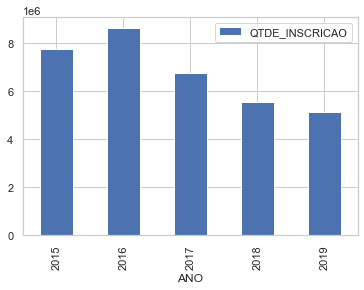

In [244]:
df_grafico = sqlContext.sql('SELECT NU_ANO AS ANO, COUNT(*) AS QTDE_INSCRICAO, ROUND((COUNT(*)/(SELECT COUNT(*)/100 FROM enemtb)),2) AS PERCENTUAL FROM enemtb GROUP BY NU_ANO ORDER BY NU_ANO, COUNT(*)').toPandas()
df_grafico.plot(kind='bar', x='ANO', y='QTDE_INSCRICAO')

<AxesSubplot:xlabel='NU_ANO'>

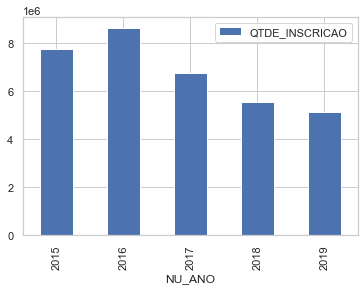

In [245]:
df_grafico = df_enem_analise.groupBy('NU_ANO').agg(count('NU_INSCRICAO').alias('QTDE_INSCRICAO')).orderBy('NU_ANO').toPandas()
df_grafico.plot(kind='bar', x='NU_ANO')

<AxesSubplot:xlabel='NU_ANO'>

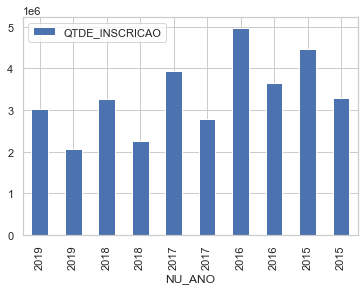

In [246]:
df_grafico = df_enem_analise.groupBy('SEXO', 'NU_ANO').agg(count('NU_INSCRICAO').alias('QTDE_INSCRICAO')).orderBy('NU_ANO', 'QTDE_INSCRICAO', ascending = False).toPandas()
df_grafico.plot(kind='bar', x='NU_ANO')